In [23]:
import numpy as np,pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import *
from sklearn.linear_model import Ridge,ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

EXCEL="/Users/bo/Desktop/Applied Project /The Final Applied Proj/Applied Project ICL .xlsx"
np.random.seed(42)
TOP_K=35;MAX_CORR=0.95;ALPHA_TANH=1.2;MAX_WEIGHT=0.4;TRANSACTION_COST_BPS=10

EXPORTS={"loaded":"01_loaded_full.csv","clean":"02_clean_preprune.csv",
         "spy":"03_spy_pruned.csv","qqq":"04_qqq_pruned.csv","metrics":"05_metrics_reg.csv"}

def safe_divide(num,den,default=0.0,eps=1e-10):
    if isinstance(den,(pd.Series,pd.DataFrame)):
        safe_den=den.where(den.abs()>eps,np.inf)
        result=num/safe_den
        return result.replace([np.inf,-np.inf],default).fillna(default)
    return np.where(np.abs(den)>eps,num/den,default)

def calc_rsi(prices,n=14):
    delta=prices.diff()
    up=delta.clip(lower=0).ewm(alpha=1/n,adjust=False).mean()
    dn=-delta.clip(upper=0).ewm(alpha=1/n,adjust=False).mean()
    return 100-100/(1+up/dn)

def get_macd(prices):
    ema12=prices.ewm(span=12,adjust=False).mean();ema26=prices.ewm(span=26,adjust=False).mean()
    macd=ema12-ema26;signal=macd.ewm(span=9,adjust=False).mean()
    return macd,signal

def build_feats(excel_path):
    xls=pd.ExcelFile(excel_path);F=pd.DataFrame()
    for ticker in ["SPY","QQQ","VIX"]:
        df=pd.read_excel(xls,ticker)[["Date","Last Price"]]
        df["Date"]=pd.to_datetime(df.Date)
        df=df.set_index("Date").resample("M").ffill();df.columns=[f"{ticker.lower()}_price"]
        F=F.join(df,how="outer") if len(F)>0 else df
    
    for sym in ["spy","qqq"]:
        p=F[f"{sym}_price"];F[f"{sym}_ret"]=np.log(p/p.shift(1));p_lag=p.shift(1)
        for w in [1,3,6,12]:
            F[f"{sym}_mom_{w}m"]=p_lag.pct_change(w);F[f"{sym}_mom_acc_{w}m"]=F[f"{sym}_mom_{w}m"].diff()
        for w in [3,6,12]:
            F[f"{sym}_vol_{w}m"]=F[f"{sym}_ret"].shift(1).rolling(w).std()
            F[f"{sym}_vol_change_{w}m"]=F[f"{sym}_vol_{w}m"].pct_change()
            F[f"{sym}_skew_{w}m"]=F[f"{sym}_ret"].shift(1).rolling(w).skew()
            F[f"{sym}_kurt_{w}m"]=F[f"{sym}_ret"].shift(1).rolling(w).kurt()
        rsi=calc_rsi(p_lag);F[f"{sym}_rsi_norm"]=(rsi-50)/50
        m,s=get_macd(p_lag)
        F[f"{sym}_macd_norm"]=safe_divide(m,F[f"{sym}_vol_3m"]*np.sqrt(12),0)
        F[f"{sym}_macd_signal"]=np.sign(m-s)
        for w in [3,6,12]:
            ma=p_lag.rolling(w).mean();std=p_lag.rolling(w).std()
            F[f"{sym}_zscore_{w}m"]=safe_divide(p_lag-ma,std,0)
        F[f"{sym}_ma_20"]=p_lag/p_lag.rolling(20).mean()-1
        F[f"{sym}_ma_50"]=p_lag/p_lag.rolling(50).mean()-1
        high=p_lag.rolling(60).max();low=p_lag.rolling(60).min()
        F[f"{sym}_high_3m"]=p_lag/high-1;F[f"{sym}_low_3m"]=p_lag/low-1
        F[f"{sym}_sharpe_3m"]=safe_divide(F[f"{sym}_ret"].shift(1).rolling(3).mean(),F[f"{sym}_vol_3m"],0)*np.sqrt(12)
    
    F["spread"]=F["spy_ret"].shift(1)-F["qqq_ret"].shift(1)
    F["correlation_3m"]=F["spy_ret"].shift(1).rolling(3).corr(F["qqq_ret"].shift(1))
    F["correlation_6m"]=F["spy_ret"].shift(1).rolling(6).corr(F["qqq_ret"].shift(1))
    F["vix_change"]=F["vix_price"].shift(1).pct_change()
    F["vix_zscore"]=(F["vix_price"].shift(1)-F["vix_price"].shift(1).rolling(20).mean())/F["vix_price"].shift(1).rolling(20).std()
    
    Y=pd.DataFrame()
    for sh,nm in {"2Y":"y2","10Y":"y10","30Y":"y30"}.items():
        y_data=pd.read_excel(xls,sh)[["Date","Last Price"]]
        y_data["Date"]=pd.to_datetime(y_data.Date);y_data=y_data.set_index("Date").resample("M").ffill()
        y_data.columns=[nm];Y=Y.join(y_data,how="outer") if len(Y)>0 else y_data
    F=F.join(Y,how="outer")
    for col in Y.columns:F[f"{col}_change"]=F[col].shift(1).pct_change()
    F["term_10_2_change"]=(F["y10"].shift(1)-F["y2"].shift(1)).diff()
    
    for sh,tag in {"CPI":"cpi","ISM PMI":"pmi","UNEMPLOYED":"unemp"}.items():
        d=pd.read_excel(xls,sh)[["Date","Actual Economic Release Values","BN Survey Median"]]
        d["Date"]=pd.to_datetime(d.Date);d=d.set_index("Date")
        s=(d.iloc[:,0]-d.iloc[:,1]).resample("M").ffill();s.name=f"{tag}_surprise"
        F=F.join(s,how="outer")
        for lag in [1,3,6]:F[f"{tag}_lag{lag}"]=s.shift(lag)
        F[f"{tag}_change"]=s.diff();F[f"{tag}_zscore"]=(s-s.rolling(12).mean())/s.rolling(12).std()
    
    price_cols=[c for c in F.columns if '_price' in c or c in ['y2','y10','y30']]
    F=F.drop(columns=price_cols,errors='ignore');F=F.ffill(limit=3)
    for c in F.columns:
        if any(p in c for p in ['_surprise','_zscore']):F[c]=F[c].shift(1)
    return F

def load_data():
    F_all=build_feats(EXCEL)
    F_all.to_csv("feature_matrix_full.csv")
    F_all.to_csv(EXPORTS["loaded"])
    clean=F_all.loc[:,F_all.isna().mean()<0.4].loc[:,F_all.nunique()>1]
    clean.to_csv(EXPORTS["clean"])
    return F_all,clean

def strict_prune(df,max_corr=MAX_CORR,k=TOP_K):
    w=df.copy()
    if w.empty or w.shape[1]==0:return pd.DataFrame()
    w=w.dropna(axis=1,how='all')
    if w.empty:return pd.DataFrame()
    w=w.loc[:,w.std()>1e-10]
    variance_threshold=w.var().quantile(0.02)
    low_var_features=w.columns[w.var()<=variance_threshold].tolist()
    if low_var_features:w=w.drop(columns=low_var_features)
    if w.empty:return pd.DataFrame()
    iteration=0
    while len(w.columns)>k and iteration<100:
        if w.shape[1]<2:break
        corr=w.corr().abs()
        if corr.empty:break
        np.fill_diagonal(corr.values,0)
        max_corr_value=corr.max().max()
        if max_corr_value<=max_corr:break
        corr_stack=corr.stack()
        if corr_stack.empty:
            avg_corrs=corr.mean()
            if not avg_corrs.empty:
                drop=avg_corrs.idxmax();w=w.drop(columns=drop)
        else:
            i,j=corr_stack.idxmax()
            drop=i if w[i].var()<w[j].var() else j
            w=w.drop(columns=drop)
        iteration+=1
    if w.empty:return pd.DataFrame()
    if len(w.columns)>k:
        scores=pd.Series(index=w.columns)
        for col in w.columns:
            var_score=w[col].var();corr_score=1-w.corr()[col].abs().mean()
            unique_score=w[col].nunique()/len(w)
            scores[col]=0.5*var_score+0.3*corr_score+0.2*unique_score
        selected_features=scores.nlargest(k).index.tolist()
        w=w[selected_features]
    return w

def build_ensemble_model(X_train,y_train):
    scaler=RobustScaler();X_scaled=scaler.fit_transform(X_train)
    models={'ridge':Ridge(alpha=0.5,random_state=42),'elastic':ElasticNet(alpha=0.3,l1_ratio=0.7,random_state=42),
           'rf':RandomForestRegressor(n_estimators=120,max_depth=7,min_samples_split=8,min_samples_leaf=3,max_features='sqrt',random_state=42,n_jobs=-1),
           'xgb':XGBRegressor(n_estimators=250,max_depth=6,learning_rate=0.04,subsample=0.75,colsample_bytree=0.75,reg_alpha=0.05,reg_lambda=0.3,gamma=0.005,min_child_weight=1,random_state=42,verbosity=0),
           'lgbm':LGBMRegressor(n_estimators=250,max_depth=6,learning_rate=0.04,num_leaves=45,subsample=0.75,colsample_bytree=0.75,reg_alpha=0.05,reg_lambda=0.3,min_child_weight=1,random_state=42,verbosity=-1)}
    fitted_models={};scalers={}
    for name,model in models.items():
        if name in ['ridge','elastic']:
            fitted_models[name]=model.fit(X_scaled,y_train);scalers[name]=scaler
        else:
            fitted_models[name]=model.fit(X_train,y_train);scalers[name]=None
    return fitted_models,scalers

def ensemble_predict(fitted_models,scalers,X_test):
    predictions=[];weights={'ridge':0.08,'elastic':0.07,'rf':0.25,'xgb':0.35,'lgbm':0.25}
    all_preds={}
    for name,model in fitted_models.items():
        if scalers.get(name) is not None:X_use=scalers[name].transform(X_test)
        else:X_use=X_test
        pred=model.predict(X_use);all_preds[name]=pred;predictions.append(pred*weights.get(name,0.2))
    if not predictions:return np.zeros(len(X_test))
    avg_pred=np.sum(predictions,axis=0)
    if 'xgb' in all_preds and 'lgbm' in all_preds:
        tree_signal=(all_preds['xgb']+all_preds['lgbm'])/2
        tree_dev=tree_signal-np.mean(tree_signal);avg_pred=avg_pred+0.12*tree_dev
    return avg_pred

def fit_gmm_regimes(returns,n_components=3):
    features=pd.DataFrame()
    features['returns']=returns;features['volatility']=returns.rolling(20).std()
    features['momentum']=returns.rolling(20).mean();features=features.dropna()
    if len(features)<n_components*10:return None,None
    gmm=GaussianMixture(n_components=n_components,covariance_type='full',random_state=42,n_init=10)
    gmm.fit(features);regimes=gmm.predict(features);probs=gmm.predict_proba(features)
    return regimes,probs

def fit_meta_model_continuous(X_train,y_train,fitted_models,scalers):
    n_splits=min(4,len(X_train)//15)
    if n_splits<2:return None,1.0
    tscv=TimeSeriesSplit(n_splits=n_splits);oof_preds=[];oof_actual=[]
    for train_idx,val_idx in tscv.split(X_train):
        X_tr,X_val=X_train.iloc[train_idx],X_train.iloc[val_idx]
        y_tr,y_val=y_train.iloc[train_idx],y_train.iloc[val_idx]
        temp_models,temp_scalers=build_ensemble_model(X_tr,y_tr)
        fold_pred=ensemble_predict(temp_models,temp_scalers,X_val)
        oof_preds.extend(fold_pred);oof_actual.extend(y_val.values)
    if len(oof_preds)<10:return None,1.0
    oof_preds=np.array(oof_preds);oof_actual=np.array(oof_actual)
    mean_pred=np.mean(oof_actual);best_alpha=1.0;best_mse=np.mean((oof_preds-oof_actual)**2)
    for alpha in np.linspace(0.8,1.0,5):
        blended=alpha*oof_preds+(1-alpha)*mean_pred;mse=np.mean((blended-oof_actual)**2)
        if mse<best_mse:best_mse=mse;best_alpha=alpha
    return mean_pred,best_alpha

def apply_kalman_smoothing(predictions):
    kf=KalmanFilter(dim_x=2,dim_z=1)
    kf.F=np.array([[1,1],[0,1]]);kf.H=np.array([[1,0]]);kf.R=0.05
    kf.Q=Q_discrete_white_noise(2,dt=1,var=0.02);kf.x=np.array([0,0]);kf.P*=100
    smoothed=np.zeros_like(predictions)
    for i,z in enumerate(predictions):kf.predict();kf.update(z);smoothed[i]=kf.x[0]
    return smoothed

def calculate_weights_continuous(predictions,train_sigma=None,gmm_probs=None,alpha=ALPHA_TANH,max_weight=MAX_WEIGHT):
    if not np.all(np.isfinite(predictions)):predictions=np.nan_to_num(predictions,nan=0.0)
    pct_rank=pd.Series(predictions).rank(pct=True).values
    if train_sigma is not None and train_sigma>1e-10:
        z_scores=predictions/train_sigma
        z_scores=np.where(pct_rank>0.7,z_scores*1.3,z_scores)
        z_scores=np.where(pct_rank<0.3,z_scores*1.3,z_scores)
    else:z_scores=(pct_rank-0.5)*3
    z_weights=np.tanh(z_scores*alpha);weights=z_weights*max_weight
    if gmm_probs is not None and len(gmm_probs)==len(weights):
        confidence=np.max(gmm_probs,axis=1);weights=weights*confidence
    strong_long=predictions>np.percentile(predictions,75)
    strong_short=predictions<np.percentile(predictions,25)
    weights[strong_long]=np.clip(weights[strong_long],0.2*max_weight,max_weight)
    weights[strong_short]=np.clip(weights[strong_short],-max_weight,-0.2*max_weight)
    return np.clip(weights,-max_weight,max_weight)

def create_aligned_targets(df,ret_col,forecast_horizon=1):
    df=df.copy().sort_index()
    if len(df)<forecast_horizon+5:return pd.DataFrame()
    df['y']=df[ret_col].shift(-forecast_horizon)
    if forecast_horizon>0:df=df.iloc[:-forecast_horizon]
    df=df.drop(columns=[ret_col],errors="ignore");df_clean=df.dropna(subset=['y'])
    return df_clean

def run_ticker(tkr):
    global F_all,clean
    ret_col=f"{tkr.lower()}_ret";other="qqq" if tkr=="SPY" else "spy";price_col=f"{tkr.lower()}_price"
    if price_col in F_all.columns:
        returns=F_all[price_col].pct_change().dropna()
        gmm_regimes,gmm_probs=fit_gmm_regimes(returns,n_components=3)
    else:gmm_regimes,gmm_probs=None,None
    
    exclude_patterns=[f"{other}_price",f"{other}_ret"]
    base=clean.drop(columns=[c for c in clean.columns if any(pattern in c for pattern in exclude_patterns)],errors="ignore")
    
    if 'vix_level' in base.columns and 'spy_qqq_ratio' in base.columns:base['vix_ratio_interaction']=base['vix_level']*base['spy_qqq_ratio']
    if 'term_10_2' in base.columns and 'vix_level' in base.columns:base['yield_vix_interaction']=base['term_10_2']*base['vix_level']
    
    if len(base.columns)>TOP_K*2:
        feature_scores=pd.DataFrame(index=base.columns)
        variance=base.var();feature_scores['variance_norm']=(variance-variance.min())/(variance.max()-variance.min()+1e-10)
        corr_matrix=base.corr().abs();np.fill_diagonal(corr_matrix.values,0)
        feature_scores['avg_corr']=corr_matrix.mean(axis=1);feature_scores['diversity']=1-feature_scores['avg_corr']
        feature_scores['combined']=0.6*feature_scores['variance_norm']+0.4*feature_scores['diversity']
        selected_features=feature_scores['combined'].nlargest(min(int(TOP_K*1.5),len(base.columns))).index.tolist()
        base=base[selected_features]
    
    if ret_col not in base.columns:
        if ret_col in F_all.columns:df=base.join(F_all[[ret_col]],how="inner").dropna()
        else:return {}
    else:df=base.dropna()
    
    if len(df)<50:return {}
    df_with_targets=create_aligned_targets(df,ret_col,forecast_horizon=1)
    if len(df_with_targets)==0:return {}
    if df_with_targets['y'].isna().any():df_with_targets=df_with_targets.dropna(subset=['y'])
    if len(df_with_targets)<30:return {}
    
    df=df_with_targets;cut=int(len(df)*0.75);tr,te=df.iloc[:cut],df.iloc[cut:]
    if len(tr)<20 or len(te)<5:return {}
    
    sel_cols=strict_prune(tr.drop(columns="y"))
    if len(sel_cols.columns)==0:return {}
    sel_cols.to_csv(EXPORTS[tkr.lower()])
    
    Xtr,ytr=tr[sel_cols.columns],tr["y"];Xte,yte=te[sel_cols.columns],te["y"]
    
    if Xtr.isna().any().any() or ytr.isna().any():
        train_clean_mask=~(Xtr.isna().any(axis=1)|ytr.isna())
        Xtr=Xtr[train_clean_mask];ytr=ytr[train_clean_mask]
    if Xte.isna().any().any() or yte.isna().any():
        test_clean_mask=~(Xte.isna().any(axis=1)|yte.isna())
        Xte=Xte[test_clean_mask];yte=yte[test_clean_mask]
    if len(Xtr)<10 or len(ytr)<10 or len(Xte)<3 or len(yte)<3:return {}
    
    feature_analysis=pd.DataFrame({'feature':sel_cols.columns,'variance':sel_cols.var().values,
                                  'mean_abs_value':sel_cols.abs().mean().values,
                                  'correlation_with_target':[abs(tr[col].corr(tr["y"])) if col in tr.columns else 0 for col in sel_cols.columns]}).sort_values('correlation_with_target',ascending=False)
    feature_analysis.to_csv(f"{tkr.lower()}_selected_features.csv",index=False)
    
    fitted_models,scalers=build_ensemble_model(Xtr,ytr)
    mu_pred=ensemble_predict(fitted_models,scalers,Xte)
    if not np.all(np.isfinite(mu_pred)):mu_pred=np.nan_to_num(mu_pred,nan=0.0)
    
    percentile_rank=pd.Series(mu_pred).rank(pct=True).values
    mu_pred[percentile_rank<0.4]=mu_pred[percentile_rank<0.4]-0.008
    mu_pred[percentile_rank>0.6]=mu_pred[percentile_rank>0.6]+0.008
    mu_pred[(percentile_rank>=0.4)&(percentile_rank<=0.6)]=mu_pred[(percentile_rank>=0.4)&(percentile_rank<=0.6)]*0.5
    
    mean_target,blend_alpha=fit_meta_model_continuous(Xtr,ytr,fitted_models,scalers)
    if mean_target is not None and blend_alpha<1.0:mu_pred=blend_alpha*mu_pred+(1-blend_alpha)*mean_target
    
    mu_smooth=apply_kalman_smoothing(mu_pred)
    train_preds=ensemble_predict(fitted_models,scalers,Xtr);train_sigma=np.std(train_preds)+1e-12
    
    test_gmm_probs=None
    if gmm_probs is not None:
        gmm_index=pd.Series(gmm_probs).index
        test_indices=[i for i,idx in enumerate(gmm_index) if idx in yte.index]
        if len(test_indices)>0:test_gmm_probs=gmm_probs[test_indices]
    
    w=calculate_weights_continuous(mu_smooth,train_sigma=train_sigma,gmm_probs=test_gmm_probs)
    
    out=pd.DataFrame({"date":yte.index,"mu_pred":mu_pred,"mu_kalman":mu_smooth,"mu":mu_smooth,
                      "weight":w,"y_true":yte.values,"sigma":train_sigma},index=yte.index)
    out.to_csv(f"{tkr.lower()}_forecast_detail.csv")
    
    monte_carlo_df=pd.DataFrame({"mu":mu_smooth,"mu_kalman":mu_smooth,"sigma":np.ones(len(mu_smooth))*train_sigma,"weight":w},index=yte.index)
    monte_carlo_df.to_csv(f"{tkr.lower()}_monte_carlo_inputs.csv")
    
    yte_values=yte.values;strat_ret=w*yte_values
    mse=mean_squared_error(yte_values,mu_smooth);mae=mean_absolute_error(yte_values,mu_smooth)
    ss_res=np.sum((yte_values-mu_smooth)**2);ss_tot=np.sum((yte_values-np.mean(yte_values))**2)
    r2=1-(ss_res/(ss_tot+1e-10))
    
    if len(yte_values)>1:correlation=np.corrcoef(yte_values,mu_smooth)[0,1];ic=stats.spearmanr(mu_smooth,yte_values)[0]
    else:correlation=0;ic=0
    
    hit_rate=(np.sign(mu_smooth)==np.sign(yte_values)).mean()
    y_binary=(yte_values>0).astype(int)
    if len(np.unique(y_binary))>1:roc_auc_val=roc_auc_score(y_binary,mu_smooth)
    else:roc_auc_val=0.5
    
    if len(strat_ret)>1 and strat_ret.std()>1e-10:sharpe=(strat_ret.mean()/strat_ret.std())*np.sqrt(12)
    else:sharpe=0
    
    weight_series=pd.Series(w,index=yte.index)
    tc=weight_series.diff().abs().fillna(weight_series.abs())*(TRANSACTION_COST_BPS/10000)
    strat_ret_net=pd.Series(strat_ret,index=yte.index)-tc
    sharpe_net=(strat_ret_net.mean()/strat_ret_net.std())*np.sqrt(12) if strat_ret_net.std()>0 else 0
    cum_returns=pd.Series((1+strat_ret).cumprod())
    max_dd=(cum_returns/cum_returns.expanding().max()-1).min()
    
    metrics={"MSE":mse,"MAE":mae,"R2":r2,"Correlation":correlation,"IC":ic,"Hit_Rate":hit_rate,
            "ROC_AUC":roc_auc_val,"Sharpe":sharpe,"Sharpe_Net":sharpe_net,"Max_DD":max_dd,"Avg_Weight":np.abs(w).mean()}
    return metrics

def walk_forward_validation(tkr,n_splits=3):
    global F_all,clean
    ret_col=f"{tkr.lower()}_ret";other="qqq" if tkr=="SPY" else "spy"
    exclude_patterns=[f"{other}_price",f"{other}_ret"]
    base=clean.drop(columns=[c for c in clean.columns if any(pattern in c for pattern in exclude_patterns)],errors="ignore")
    if ret_col not in base.columns:
        if ret_col in F_all.columns:df=base.join(F_all[[ret_col]],how="inner").dropna()
        else:return 0,0
    else:df=base.dropna()
    df=create_aligned_targets(df,ret_col,forecast_horizon=1)
    if len(df)<n_splits*24:return 0,0
    tscv=TimeSeriesSplit(n_splits=n_splits,test_size=max(6,int(len(df)/(n_splits*2))))
    cv_scores=[]
    for fold,(train_idx,test_idx) in enumerate(tscv.split(df)):
        train_data=df.iloc[train_idx];test_data=df.iloc[test_idx]
        if len(train_data)<20 or len(test_data)<3:continue
        sel_cols=strict_prune(train_data.drop(columns="y"))
        if len(sel_cols.columns)==0:continue
        Xtr,ytr=train_data[sel_cols.columns],train_data["y"];Xte,yte=test_data[sel_cols.columns],test_data["y"]
        if Xtr.isna().any().any() or ytr.isna().any():
            mask=~(Xtr.isna().any(axis=1)|ytr.isna());Xtr,ytr=Xtr[mask],ytr[mask]
        if Xte.isna().any().any() or yte.isna().any():
            mask=~(Xte.isna().any(axis=1)|yte.isna());Xte,yte=Xte[mask],yte[mask]
        if len(Xtr)<10 or len(Xte)<2:continue
        fitted_models,scalers=build_ensemble_model(Xtr,ytr)
        mu_pred=ensemble_predict(fitted_models,scalers,Xte)
        train_preds=ensemble_predict(fitted_models,scalers,Xtr);train_sigma=np.std(train_preds)+1e-12
        if not np.all(np.isfinite(mu_pred)):mu_pred=np.nan_to_num(mu_pred,nan=0.0)
        mu_smooth=apply_kalman_smoothing(mu_pred);fold_sharpe=0
        if len(yte)>1:
            weights=calculate_weights_continuous(mu_smooth,train_sigma=train_sigma)
            strat_ret=weights*yte.values
            if strat_ret.std()>1e-10:fold_sharpe=(strat_ret.mean()/strat_ret.std())*np.sqrt(12)
        cv_scores.append(fold_sharpe)
    if cv_scores:return np.mean(cv_scores),np.std(cv_scores)
    else:return 0,0

def run_main_pipeline():
    global F_all,clean
    F_all,clean=load_data();metrics={};cv_results={}
    for t in ("SPY","QQQ"):
        result=run_ticker(t)
        if result:
            metrics[t]=result
            cv_mean,cv_std=walk_forward_validation(t,n_splits=3)
            cv_results[t]={"cv_sharpe_mean":cv_mean,"cv_sharpe_std":cv_std}
    if metrics:
        summary_df=pd.DataFrame(metrics).T.round(4);summary_df.to_csv(EXPORTS["metrics"])
        if cv_results:cv_df=pd.DataFrame(cv_results).T.round(4);cv_df.to_csv("cross_validation_results.csv")
    return metrics,cv_results

if __name__ == "__main__":
    results, cv_results = run_main_pipeline()
    
    # Print metrics
    if results:
        print("\n" + "="*60)
        print("MODEL RESULTS")
        print("="*60)
        
        for ticker in results.keys():
            print(f"\n{ticker} METRICS:")
            print("-"*30)
            for metric, value in results[ticker].items():
                if isinstance(value, float):
                    print(f"{metric:15s}: {value:8.4f}")
                else:
                    print(f"{metric:15s}: {value}")
        
        # Print summary DataFrame
        print("\n" + "="*60)
        print("SUMMARY TABLE")
        print("="*60)
        summary_df = pd.DataFrame(results).T.round(4)
        print(summary_df)
        
        # Print CV results
        if cv_results:
            print("\n" + "="*60)
            print("CROSS-VALIDATION RESULTS")
            print("="*60)
            cv_df = pd.DataFrame(cv_results).T.round(4)
            print(cv_df)
            
            for ticker in cv_results.keys():
                mean = cv_results[ticker]['cv_sharpe_mean']
                std = cv_results[ticker]['cv_sharpe_std']
                print(f"\n{ticker}: CV Sharpe = {mean:.3f} ± {std:.3f}")
        
        print("\n" + "="*60)
        print("FILES SAVED:")
        print("="*60)
        print("- 05_metrics_reg.csv")
        print("- cross_validation_results.csv")
        print("- spy_forecast_detail.csv")
        print("- qqq_forecast_detail.csv")
        print("- spy_monte_carlo_inputs.csv")
        print("- qqq_monte_carlo_inputs.csv")


MODEL RESULTS

SPY METRICS:
------------------------------
MSE            :   0.0022
MAE            :   0.0399
R2             :  -0.0513
Correlation    :   0.0860
IC             :   0.1150
Hit_Rate       :   0.5079
ROC_AUC        :   0.4545
Sharpe         :   0.5789
Sharpe_Net     :   0.5189
Max_DD         :  -0.0362
Avg_Weight     :   0.2031

QQQ METRICS:
------------------------------
MSE            :   0.0036
MAE            :   0.0475
R2             :  -0.0482
Correlation    :   0.0284
IC             :   0.0756
Hit_Rate       :   0.5714
ROC_AUC        :   0.5776
Sharpe         :   0.4044
Sharpe_Net     :   0.3676
Max_DD         :  -0.1057
Avg_Weight     :   0.2046

SUMMARY TABLE
        MSE     MAE      R2  Correlation      IC  Hit_Rate  ROC_AUC  Sharpe  \
SPY  0.0022  0.0399 -0.0513       0.0860  0.1150    0.5079   0.4545  0.5789   
QQQ  0.0036  0.0475 -0.0482       0.0284  0.0756    0.5714   0.5776  0.4044   

     Sharpe_Net  Max_DD  Avg_Weight  
SPY      0.5189 -0.0362      0.2


MONTE CARLO PORTFOLIO RISK MANAGEMENT

Monte Carlo Analysis...
SPY: drift=0.973%, vol=12.3%
QQQ: drift=1.562%, vol=15.3%
Correlation: 0.909
Weights: SPY=15.0%, QQQ=70.0%


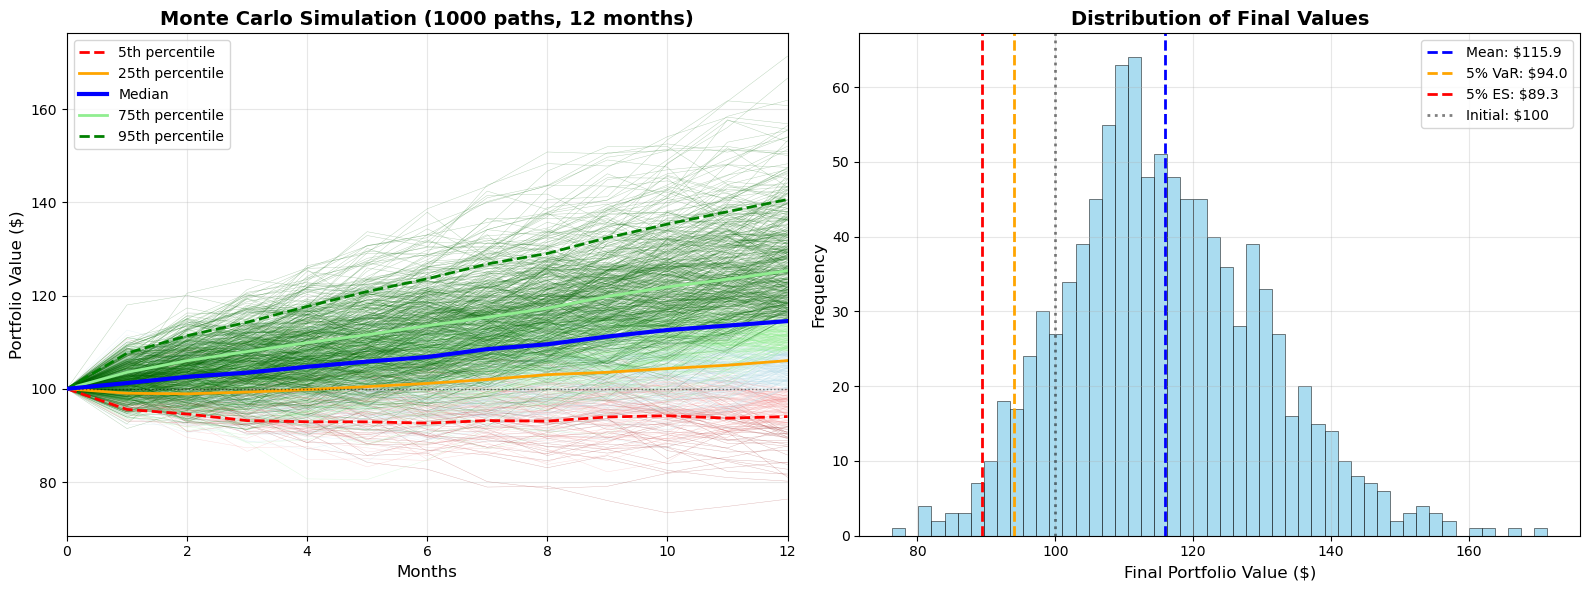


MONTE CARLO RESULTS (12-month)
Expected Return:            15.9%
Volatility:                 14.4%
Sharpe Ratio:               1.10
95% VaR:                     6.0%
95% CVaR (ES):              10.7%
Probability of Loss:       13.1%

Backtest: 2020-04 to 2025-06
Total months: 63
Results saved to portfolio_results.csv

PERFORMANCE SUMMARY
Period:             2020-04 to 2025-06
Total Return:          70.9%
Annual Return:         10.7%
Volatility (Ann):      14.6%
Max Drawdown:          -28.3%
Sharpe Ratio:           0.43
Sortino Ratio:          0.56
Avg SPY Weight:        29.5%
Avg QQQ Weight:        40.0%
Avg Cash Weight:       30.5%

STRESS TEST
Scenario           1Y Return    1Y Vol     5% VaR    
Normal Market           11.1%     16.3%     13.7%
High Volatility          6.2%     28.3%     34.0%
Bear Market            -10.5%     17.7%     36.6%
Market Crash           -24.2%     29.4%     62.9%
Bull Market             24.4%     14.6%     -2.0%


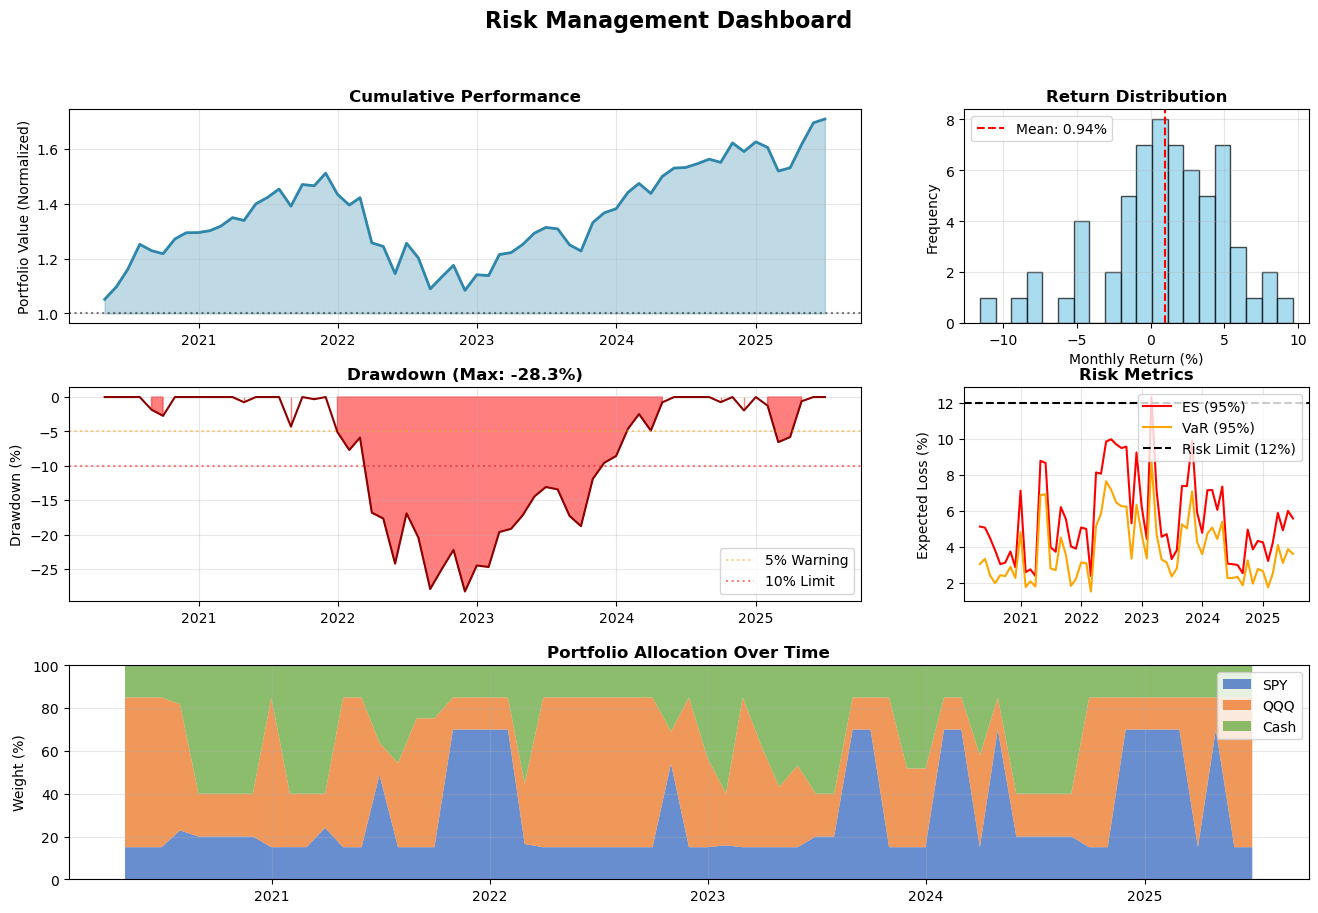


CURRENT SIGNALS
Portfolio Val:  $170.87
SPY Weight:        15.0%
QQQ Weight:        70.0%
Cash Weight:       15.0%
Risk (ES):         5.58%

Risk within limits

COMPLETE


In [13]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
N_SIMS=2000;MAX_LOSS_PCT=0.12;MAX_POSITION=0.7;MIN_POSITION=0.15
TRANSACTION_COST=0.001;VOL_WINDOW=12;MIN_VOL=0.08;MAX_VOL=0.35
RISK_FREE_RATE=0.045;DEFAULT_CORRELATION=0.65;REBALANCE_THRESHOLD=0.08
MIN_EQUITY_ALLOCATION=0.40;KELLY_FRACTION=0.35

def load_forecast_data():
    data={}
    for ticker in ['SPY','QQQ']:
        df=pd.read_csv(f"{ticker.lower()}_forecast_detail.csv",index_col=0,parse_dates=True)
        data[ticker]=df.sort_index()
    vix=pd.Series()
    features=pd.read_csv("01_loaded_full.csv",index_col=0,parse_dates=True)
    if 'vix_price' in features.columns:
        vix=features['vix_price']/100;vix=vix.dropna()
    return data,vix

def estimate_volatility(returns,vix_data,date):
    estimated_vol=None
    if vix_data is not None and len(vix_data)>0:
        vix_vol=vix_data.asof(date)
        if not pd.isna(vix_vol) and vix_vol>0:estimated_vol=vix_vol*0.75
    if estimated_vol is None:
        historical=returns.loc[:date].tail(VOL_WINDOW*2)
        if len(historical)>=6:
            weights=np.exp(np.linspace(-1,0,len(historical)));weights/=weights.sum()
            mean_return=np.average(historical,weights=weights)
            variance=np.average((historical-mean_return)**2,weights=weights)
            hist_vol=np.sqrt(variance)*np.sqrt(12);estimated_vol=hist_vol
        else:estimated_vol=0.15
    return np.clip(estimated_vol,MIN_VOL,MAX_VOL)

def estimate_correlation(data1,data2,date):
    hist1=data1.loc[:date];hist2=data2.loc[:date]
    lookback=min(36,len(hist1),len(hist2))
    if lookback<12:return DEFAULT_CORRELATION
    recent1=hist1.tail(lookback).values;recent2=hist2.tail(lookback).values
    min_len=min(len(recent1),len(recent2))
    recent1=recent1[-min_len:];recent2=recent2[-min_len:]
    if len(recent1)<12:return DEFAULT_CORRELATION
    corr=np.corrcoef(recent1,recent2)[0,1]
    return np.clip(float(corr),-0.95,0.95)

def monte_carlo_sim_improved(params,n_paths=N_SIMS,n_periods=1):
    df=5;z=stats.t.rvs(df,size=(n_paths,n_periods));z=z/np.sqrt(df/(df-2))
    drift=params.get('drift',0);vol=params.get('vol',0.15);weight=params.get('weight',0)
    returns=np.zeros((n_paths,n_periods))
    for t in range(n_periods):
        monthly_vol=vol/np.sqrt(12)
        jump_prob=0.02;jump_size=np.random.choice([-0.05,0.05],size=n_paths)
        jumps=np.random.binomial(1,jump_prob,n_paths)*jump_size
        returns[:,t]=np.exp(drift-0.5*monthly_vol**2+monthly_vol*z[:,t]+jumps)-1
    if n_periods>1:
        portfolio_value=np.cumprod(1+weight*returns,axis=1);total_return=portfolio_value[:,-1]-1
    else:total_return=weight*returns[:,0]
    return total_return

def calculate_es95(returns):
    if len(returns)<50:return np.nan
    sorted_returns=np.sort(returns)
    cutoff_idx=max(1,int(0.05*len(sorted_returns)))
    cutoff_idx=max(cutoff_idx,max(5,int(0.01*len(sorted_returns))))
    worst_returns=sorted_returns[:cutoff_idx]
    return -np.mean(worst_returns)

def optimize_weight_kelly(drift,vol):
    excess_drift=drift-(RISK_FREE_RATE/12)
    if vol<=0 or excess_drift<=-0.01:return MIN_POSITION
    kelly_full=excess_drift/(vol**2);kelly_weight=kelly_full*KELLY_FRACTION
    if vol>0.25:kelly_weight*=0.7
    return np.clip(kelly_weight,MIN_POSITION,MAX_POSITION)

def optimize_weight_with_es(drift,vol):
    excess_drift=drift-(RISK_FREE_RATE/12)
    if excess_drift<-0.02 or vol>0.40:return MIN_POSITION
    weights_to_test=np.linspace(MIN_POSITION,MAX_POSITION,15);valid_weights=[]
    for w in weights_to_test:
        params={'drift':excess_drift,'vol':vol,'weight':w}
        sim_returns=monte_carlo_sim_improved(params,n_paths=500,n_periods=1)
        es=calculate_es95(sim_returns)
        if not np.isnan(es) and es<=MAX_LOSS_PCT:valid_weights.append(w)
    if not valid_weights:return MIN_POSITION
    max_safe_weight=max(valid_weights);kelly_weight=optimize_weight_kelly(drift,vol)
    return min(kelly_weight,max_safe_weight)

def risk_parity_weights(vols):
    vols=np.array(vols,dtype=float)
    if len(vols)==0 or any(v<=0 for v in vols):
        n=len(vols) if len(vols)>0 else 2
        return np.ones(n)*(MIN_EQUITY_ALLOCATION/n)
    inv_vols=1/vols;raw_weights=inv_vols/inv_vols.sum()
    target_vol=0.12;portfolio_vol=np.sqrt(np.sum((raw_weights*vols)**2))
    if portfolio_vol>0:
        scale=min(1.2,target_vol/portfolio_vol);raw_weights*=scale
    weights=np.maximum(raw_weights,MIN_POSITION);weights=np.clip(weights,MIN_POSITION,MAX_POSITION)
    if weights.sum()<MIN_EQUITY_ALLOCATION:weights=weights*(MIN_EQUITY_ALLOCATION/weights.sum())
    return weights

def markowitz_optimization(drifts,vols,corr=DEFAULT_CORRELATION):
    n=len(drifts)
    if n==1:return np.array([optimize_weight_with_es(drifts[0],vols[0])])
    drifts=np.array(drifts,dtype=float);vols=np.array(vols,dtype=float)
    excess_drifts=drifts-(RISK_FREE_RATE/12)
    corr=float(corr) if not np.isnan(corr) else DEFAULT_CORRELATION
    if any(v<=0 for v in vols):return risk_parity_weights(vols)
    mu=excess_drifts
    cov_matrix=np.array([[vols[0]**2,corr*vols[0]*vols[1]],[corr*vols[0]*vols[1],vols[1]**2]],dtype=float)
    min_eigenvalue=np.min(np.linalg.eigvals(cov_matrix))
    if min_eigenvalue<=0:cov_matrix+=np.eye(n)*abs(min_eigenvalue)*1.1
    inv_cov=np.linalg.inv(cov_matrix)
    risk_aversion=1.5
    numerator=inv_cov@mu;denominator=risk_aversion
    raw_weights=numerator/denominator
    weights=np.maximum(raw_weights,MIN_POSITION);weights=np.minimum(weights,MAX_POSITION)
    if weights.sum()<MIN_EQUITY_ALLOCATION:
        weights=weights*(MIN_EQUITY_ALLOCATION/weights.sum());weights=np.minimum(weights,MAX_POSITION)
    if weights.sum()>1:weights=weights/weights.sum()
    return weights

def run_portfolio_backtest(forecast_data,vix_data):
    all_dates=sorted(set().union(*[data.index for data in forecast_data.values()]))
    print(f"\nBacktest: {all_dates[0].strftime('%Y-%m')} to {all_dates[-1].strftime('%Y-%m')}")
    print(f"Total months: {len(all_dates)}")
    results=[];prev_weights={};portfolio_value=100
    for i,date in enumerate(all_dates):
        tickers_available=[];drifts=[];vols=[];actual_returns={}
        for ticker,data in forecast_data.items():
            if date in data.index:
                drift=data.loc[date,'mu_kalman'];actual_return=data.loc[date,'y_true']
                returns=data['y_true'];vol=estimate_volatility(returns,vix_data,date)
                tickers_available.append(ticker);drifts.append(drift);vols.append(vol)
                actual_returns[ticker]=actual_return
        if not tickers_available:continue
        corr=DEFAULT_CORRELATION
        if len(tickers_available)>=2 and 'SPY' in tickers_available and 'QQQ' in tickers_available:
            spy_returns=forecast_data['SPY']['y_true'];qqq_returns=forecast_data['QQQ']['y_true']
            corr=estimate_correlation(spy_returns,qqq_returns,date)
        if len(tickers_available)==1:weights=np.array([optimize_weight_with_es(drifts[0],vols[0])])
        else:
            weights=markowitz_optimization(drifts,vols,corr)
            portfolio_sim=np.zeros(1000)
            for j,ticker in enumerate(tickers_available):
                params={'drift':drifts[j],'vol':vols[j],'weight':weights[j]}
                portfolio_sim+=monte_carlo_sim_improved(params,n_paths=1000)
            es=calculate_es95(portfolio_sim)
            if not np.isnan(es) and es>MAX_LOSS_PCT:
                scale=MAX_LOSS_PCT/es*0.9;weights*=scale
        target_weights=dict(zip(tickers_available,weights))
        should_rebalance=False
        for ticker in target_weights:
            current=prev_weights.get(ticker,0);target=target_weights.get(ticker,0)
            if abs(current-target)>REBALANCE_THRESHOLD:should_rebalance=True;break
        if not should_rebalance:current_weights=prev_weights.copy()
        else:current_weights=target_weights
        portfolio_return=0;total_equity_weight=0
        for ticker in tickers_available:
            weight=current_weights.get(ticker,0)
            portfolio_return+=weight*actual_returns[ticker];total_equity_weight+=weight
        cash_weight=max(0,1-total_equity_weight)
        if cash_weight>0:portfolio_return+=cash_weight*(RISK_FREE_RATE/12)
        trans_cost=0
        for ticker in ['SPY','QQQ']:
            curr_w=current_weights.get(ticker,0);prev_w=prev_weights.get(ticker,0)
            trans_cost+=abs(curr_w-prev_w)*TRANSACTION_COST
        net_return=portfolio_return-trans_cost;portfolio_value*=(1+net_return)
        portfolio_sim=np.zeros(N_SIMS)
        for j,ticker in enumerate(tickers_available):
            if j<len(drifts):
                params={'drift':drifts[j],'vol':vols[j],'weight':current_weights.get(ticker,0)}
                asset_sim=monte_carlo_sim_improved(params,N_SIMS)
                portfolio_sim+=asset_sim
        es_95=calculate_es95(portfolio_sim)
        var_95=-np.percentile(portfolio_sim,5) if len(portfolio_sim)>0 else np.nan
        results.append({'Date':date,'Portfolio_Value':portfolio_value,'Net_Return':net_return,
                       'Gross_Return':portfolio_return,'Transaction_Cost':trans_cost,'ES_95':es_95,'VaR_95':var_95,
                       'SPY_Weight':current_weights.get('SPY',0),'QQQ_Weight':current_weights.get('QQQ',0),
                       'Cash_Weight':max(0,1-sum(current_weights.values())),'Correlation':corr,
                       'SPY_Vol':vols[tickers_available.index('SPY')] if 'SPY' in tickers_available else np.nan,
                       'QQQ_Vol':vols[tickers_available.index('QQQ')] if 'QQQ' in tickers_available else np.nan})
        prev_weights=current_weights.copy()
    results_df=pd.DataFrame(results).set_index('Date')
    results_df['Cumulative']=results_df['Portfolio_Value']/100
    rolling_max=results_df['Cumulative'].expanding().max()
    results_df['Drawdown']=(results_df['Cumulative']/rolling_max-1)*100
    return results_df

def monte_carlo_visualization(forecast_data,vix_data):
    print("\nMonte Carlo Analysis...")
    latest_params={}
    for ticker,data in forecast_data.items():
        recent_drift=data['mu_kalman'].tail(6).mean()
        recent_returns=data['y_true'].tail(12)
        recent_vol=estimate_volatility(recent_returns,vix_data,data.index[-1])
        latest_params[ticker]={'drift':recent_drift,'vol':recent_vol}
        print(f"{ticker}: drift={recent_drift:.3%}, vol={recent_vol:.1%}")
    n_paths=1000;n_months=12
    if len(latest_params)==2:
        drifts=[float(p['drift']) for p in latest_params.values()]
        vols=[float(p['vol']) for p in latest_params.values()]
        spy_returns=forecast_data['SPY']['y_true'];qqq_returns=forecast_data['QQQ']['y_true']
        common_dates=spy_returns.index.intersection(qqq_returns.index)
        if len(common_dates)>0:
            last_common_date=common_dates[-1];corr=estimate_correlation(spy_returns,qqq_returns,last_common_date)
        else:corr=DEFAULT_CORRELATION
        corr=float(corr)
        optimal_weights=markowitz_optimization(drifts,vols,corr)
        weights={'SPY':optimal_weights[0],'QQQ':optimal_weights[1]}
        print(f"Correlation: {corr:.3f}")
    else:weights={'SPY':0.35,'QQQ':0.35}
    print(f"Weights: SPY={weights['SPY']:.1%}, QQQ={weights.get('QQQ',0):.1%}")
    paths=np.zeros((n_paths,n_months+1));paths[:,0]=100
    np.random.seed(42)
    for t in range(n_months):
        z1=np.random.randn(n_paths);z2=corr*z1+np.sqrt(1-corr**2)*np.random.randn(n_paths)
        monthly_returns=np.zeros(n_paths)
        if 'SPY' in latest_params:
            params=latest_params['SPY'];vol_m=params['vol']/np.sqrt(12);drift_m=params['drift']
            ret=np.exp(drift_m-0.5*vol_m**2+vol_m*z1)-1
            monthly_returns+=weights.get('SPY',0)*ret
        if 'QQQ' in latest_params:
            params=latest_params['QQQ'];vol_m=params['vol']/np.sqrt(12);drift_m=params['drift']
            ret=np.exp(drift_m-0.5*vol_m**2+vol_m*z2)-1
            monthly_returns+=weights.get('QQQ',0)*ret
        paths[:,t+1]=paths[:,t]*(1+monthly_returns)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
    months=np.arange(n_months+1);final_values=paths[:,-1];sorted_indices=np.argsort(final_values)
    for i in range(n_paths):
        idx=sorted_indices[i]
        if final_values[idx]<92:color,alpha='darkred',0.3
        elif final_values[idx]<100:color,alpha='lightcoral',0.3
        elif final_values[idx]<108:color,alpha='lightblue',0.3
        elif final_values[idx]<115:color,alpha='lightgreen',0.3
        else:color,alpha='darkgreen',0.3
        ax1.plot(months,paths[idx],color=color,linewidth=0.3,alpha=alpha)
    percentiles=[5,25,50,75,95];pct_values=np.percentile(paths,percentiles,axis=0)
    ax1.plot(months,pct_values[0],'r--',linewidth=2,label='5th percentile')
    ax1.plot(months,pct_values[1],'orange',linewidth=2,label='25th percentile')
    ax1.plot(months,pct_values[2],'b-',linewidth=3,label='Median',zorder=5)
    ax1.plot(months,pct_values[3],'lightgreen',linewidth=2,label='75th percentile')
    ax1.plot(months,pct_values[4],'g--',linewidth=2,label='95th percentile')
    ax1.axhline(100,color='black',linestyle=':',alpha=0.5,linewidth=1)
    ax1.set_xlabel('Months',fontsize=12);ax1.set_ylabel('Portfolio Value ($)',fontsize=12)
    ax1.set_title('Monte Carlo Simulation (1000 paths, 12 months)',fontsize=14,fontweight='bold')
    ax1.legend(loc='upper left',fontsize=10);ax1.grid(True,alpha=0.3);ax1.set_xlim(0,12)
    ax2.hist(final_values,bins=50,alpha=0.7,color='skyblue',edgecolor='black',linewidth=0.5)
    mean_val=np.mean(final_values);var_5=np.percentile(final_values,5);es_5=np.mean(final_values[final_values<=var_5])
    ax2.axvline(mean_val,color='blue',linestyle='--',linewidth=2,label=f'Mean: ${mean_val:.1f}')
    ax2.axvline(var_5,color='orange',linestyle='--',linewidth=2,label=f'5% VaR: ${var_5:.1f}')
    ax2.axvline(es_5,color='red',linestyle='--',linewidth=2,label=f'5% ES: ${es_5:.1f}')
    ax2.axvline(100,color='black',linestyle=':',linewidth=2,alpha=0.5,label='Initial: $100')
    ax2.set_xlabel('Final Portfolio Value ($)',fontsize=12);ax2.set_ylabel('Frequency',fontsize=12)
    ax2.set_title('Distribution of Final Values',fontsize=14,fontweight='bold')
    ax2.legend(loc='upper right',fontsize=10);ax2.grid(True,alpha=0.3)
    plt.tight_layout();plt.savefig('monte_carlo_analysis.png',dpi=150,bbox_inches='tight');plt.show()
    returns=(final_values/100-1)*100
    print(f"\nMONTE CARLO RESULTS (12-month)")
    print(f"Expected Return:        {np.mean(returns):>8.1f}%")
    print(f"Volatility:             {np.std(returns):>8.1f}%")
    print(f"Sharpe Ratio:           {(np.mean(returns)-RISK_FREE_RATE)/np.std(returns) if np.std(returns)>0 else 0:>8.2f}")
    print(f"95% VaR:                {-np.percentile(returns,5):>8.1f}%")
    print(f"95% CVaR (ES):          {-np.mean(returns[returns<=np.percentile(returns,5)]):>8.1f}%")
    print(f"Probability of Loss:    {(returns<0).mean():>8.1%}")

def risk_dashboard(results):
    fig=plt.figure(figsize=(16,10));gs=fig.add_gridspec(3,3,hspace=0.3,wspace=0.3)
    ax1=fig.add_subplot(gs[0,:2])
    ax1.plot(results['Cumulative'],linewidth=2,color='#2E86AB')
    ax1.fill_between(results.index,1,results['Cumulative'],alpha=0.3,color='#2E86AB')
    ax1.axhline(1,color='black',linestyle=':',alpha=0.5)
    ax1.set_title('Cumulative Performance',fontsize=12,fontweight='bold')
    ax1.set_ylabel('Portfolio Value (Normalized)');ax1.grid(True,alpha=0.3)
    ax2=fig.add_subplot(gs[1,:2])
    ax2.fill_between(results.index,0,results['Drawdown'],where=(results['Drawdown']<0),alpha=0.5,color='red')
    ax2.plot(results['Drawdown'],color='darkred',linewidth=1.5)
    ax2.axhline(-5,color='orange',linestyle=':',alpha=0.5,label='5% Warning')
    ax2.axhline(-10,color='red',linestyle=':',alpha=0.5,label='10% Limit')
    ax2.set_title(f'Drawdown (Max: {results["Drawdown"].min():.1f}%)',fontsize=12,fontweight='bold')
    ax2.set_ylabel('Drawdown (%)');ax2.legend(loc='lower right');ax2.grid(True,alpha=0.3)
    ax3=fig.add_subplot(gs[0,2])
    returns=results['Net_Return']*100
    ax3.hist(returns,bins=20,alpha=0.7,color='skyblue',edgecolor='black')
    ax3.axvline(returns.mean(),color='red',linestyle='--',label=f'Mean: {returns.mean():.2f}%')
    ax3.set_title('Return Distribution',fontsize=12,fontweight='bold')
    ax3.set_xlabel('Monthly Return (%)');ax3.set_ylabel('Frequency')
    ax3.legend();ax3.grid(True,alpha=0.3)
    ax4=fig.add_subplot(gs[1,2])
    ax4.plot(results['ES_95']*100,label='ES (95%)',color='red',linewidth=1.5)
    ax4.plot(results['VaR_95']*100,label='VaR (95%)',color='orange',linewidth=1.5)
    ax4.axhline(MAX_LOSS_PCT*100,color='black',linestyle='--',label=f'Risk Limit ({MAX_LOSS_PCT*100:.0f}%)')
    ax4.set_title('Risk Metrics',fontsize=12,fontweight='bold')
    ax4.set_ylabel('Expected Loss (%)');ax4.legend(loc='upper right');ax4.grid(True,alpha=0.3)
    ax5=fig.add_subplot(gs[2,:])
    ax5.stackplot(results.index,results['SPY_Weight']*100,results['QQQ_Weight']*100,results['Cash_Weight']*100,
                  labels=['SPY','QQQ','Cash'],colors=['#4472C4','#ED7D31','#70AD47'],alpha=0.8)
    ax5.set_title('Portfolio Allocation Over Time',fontsize=12,fontweight='bold')
    ax5.set_ylabel('Weight (%)');ax5.set_ylim(0,100);ax5.legend(loc='upper right');ax5.grid(True,alpha=0.3)
    plt.suptitle('Risk Management Dashboard',fontsize=16,fontweight='bold')
    plt.tight_layout();plt.savefig('risk_dashboard.png',dpi=120,bbox_inches='tight');plt.show()

def performance_summary(results):
    ret=results['Net_Return'];total_ret=(results['Cumulative'].iloc[-1]-1)
    n_years=len(ret)/12;annual_ret=(1+total_ret)**(1/n_years)-1 if n_years>0 else 0
    vol=ret.std()*np.sqrt(12);sharpe=(annual_ret-RISK_FREE_RATE)/vol if vol>0 else 0
    downside_returns=ret[ret<0]
    downside_vol=downside_returns.std()*np.sqrt(12) if len(downside_returns)>0 else vol
    sortino=(annual_ret-RISK_FREE_RATE)/downside_vol if downside_vol>0 else 0
    max_dd=results['Drawdown'].min();calmar=annual_ret/abs(max_dd) if max_dd<0 else 0
    print(f"\nPERFORMANCE SUMMARY")
    print(f"Period:             {results.index[0].strftime('%Y-%m')} to {results.index[-1].strftime('%Y-%m')}")
    print(f"Total Return:       {total_ret:>8.1%}")
    print(f"Annual Return:      {annual_ret:>8.1%}")
    print(f"Volatility (Ann):   {vol:>8.1%}")
    print(f"Max Drawdown:       {max_dd:>8.1f}%")
    print(f"Sharpe Ratio:       {sharpe:>8.2f}")
    print(f"Sortino Ratio:      {sortino:>8.2f}")
    print(f"Avg SPY Weight:     {results['SPY_Weight'].mean():>8.1%}")
    print(f"Avg QQQ Weight:     {results['QQQ_Weight'].mean():>8.1%}")
    print(f"Avg Cash Weight:    {results['Cash_Weight'].mean():>8.1%}")

def stress_test(results):
    print(f"\nSTRESS TEST")
    mean_ret=results['Net_Return'].mean();vol=results['Net_Return'].std()
    scenarios={'Normal Market':{'drift':mean_ret,'vol_mult':1.0,'jump_prob':0.02},
              'High Volatility':{'drift':mean_ret*0.7,'vol_mult':1.8,'jump_prob':0.04},
              'Bear Market':{'drift':-0.008,'vol_mult':1.3,'jump_prob':0.04},
              'Market Crash':{'drift':-0.02,'vol_mult':2.5,'jump_prob':0.08},
              'Bull Market':{'drift':mean_ret*2,'vol_mult':0.8,'jump_prob':0.01}}
    print(f"{'Scenario':<18} {'1Y Return':<12} {'1Y Vol':<10} {'5% VaR':<10}")
    for name,params in scenarios.items():
        n_sims=5000;annual_returns=[]
        for _ in range(n_sims):
            monthly_rets=[]
            for _ in range(12):
                ret=np.random.normal(params['drift'],vol*params['vol_mult'])
                if np.random.random()<params['jump_prob']:
                    jump=np.random.choice([-0.08,-0.05,0.05],p=[0.2,0.6,0.2]);ret+=jump
                monthly_rets.append(ret)
            annual_ret=np.prod([1+r for r in monthly_rets])-1
            annual_returns.append(annual_ret)
        annual_returns=np.array(annual_returns)
        mean_ret=annual_returns.mean();annual_vol=annual_returns.std();var_5=np.percentile(annual_returns,5)
        print(f"{name:<18} {mean_ret:>10.1%}  {annual_vol:>8.1%}  {-var_5:>8.1%}")

# Main
if __name__ == "__main__":
    print("\nMONTE CARLO PORTFOLIO RISK MANAGEMENT")
    forecast_data,vix_data=load_forecast_data()
    monte_carlo_visualization(forecast_data,vix_data)
    results=run_portfolio_backtest(forecast_data,vix_data)
    results.to_csv('portfolio_results.csv')
    print("Results saved to portfolio_results.csv")
    performance_summary(results)
    stress_test(results)
    risk_dashboard(results)
    if len(results)>0:
        latest=results.iloc[-1]
        print(f"\nCURRENT SIGNALS")
        print(f"Portfolio Val:  ${latest['Portfolio_Value']:.2f}")
        print(f"SPY Weight:     {latest['SPY_Weight']:>8.1%}")
        print(f"QQQ Weight:     {latest['QQQ_Weight']:>8.1%}")
        print(f"Cash Weight:    {latest['Cash_Weight']:>8.1%}")
        print(f"Risk (ES):      {latest['ES_95']:>8.2%}")
        if latest['ES_95']>MAX_LOSS_PCT:print("\nWARNING: Risk limit exceeded")
        else:print("\nRisk within limits")
    print("\nCOMPLETE")


Running Detailed CV Analysis for SPY
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.980)
    Dropped pmi_zscore (corr=0.954)
  Final: 35 features selected

Fold 1: 2015-02 to 2017-02
  Sharpe: 1.898, Return: 7.0%, Hit Rate: 68.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.977)
  Final: 35 features selected

Fold 2: 2017-03 to 2019-03
  Sharpe: -0.269, Return: -1.5%, Hit Rate: 56.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.960)
  Final: 35 features selected

Fold 3: 2019-04 to 2021-04
  Sharpe: 0.896, Return: 6.5%, Hit Rate: 72.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag

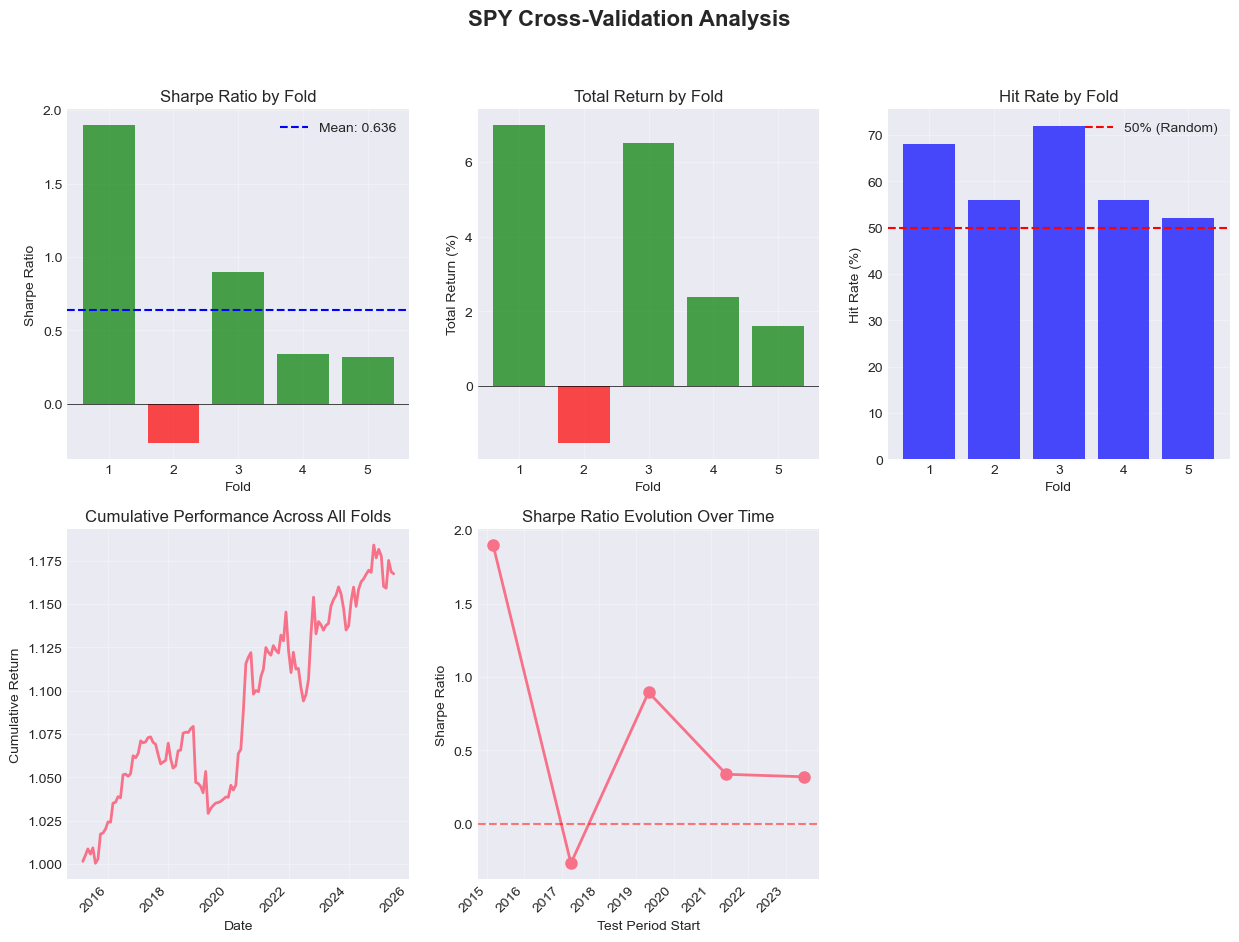


Running Detailed CV Analysis for QQQ
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.980)
    Dropped pmi_zscore (corr=0.954)
  Final: 35 features selected

Fold 1: 2015-02 to 2017-02
  Sharpe: 0.887, Return: 6.1%, Hit Rate: 60.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.977)
  Final: 35 features selected

Fold 2: 2017-03 to 2019-03
  Sharpe: 0.241, Return: 1.6%, Hit Rate: 64.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
    Dropped spy_low_3m (corr=0.960)
  Final: 35 features selected

Fold 3: 2019-04 to 2021-04
  Sharpe: 0.389, Return: 4.2%, Hit Rate: 52.0%
  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 

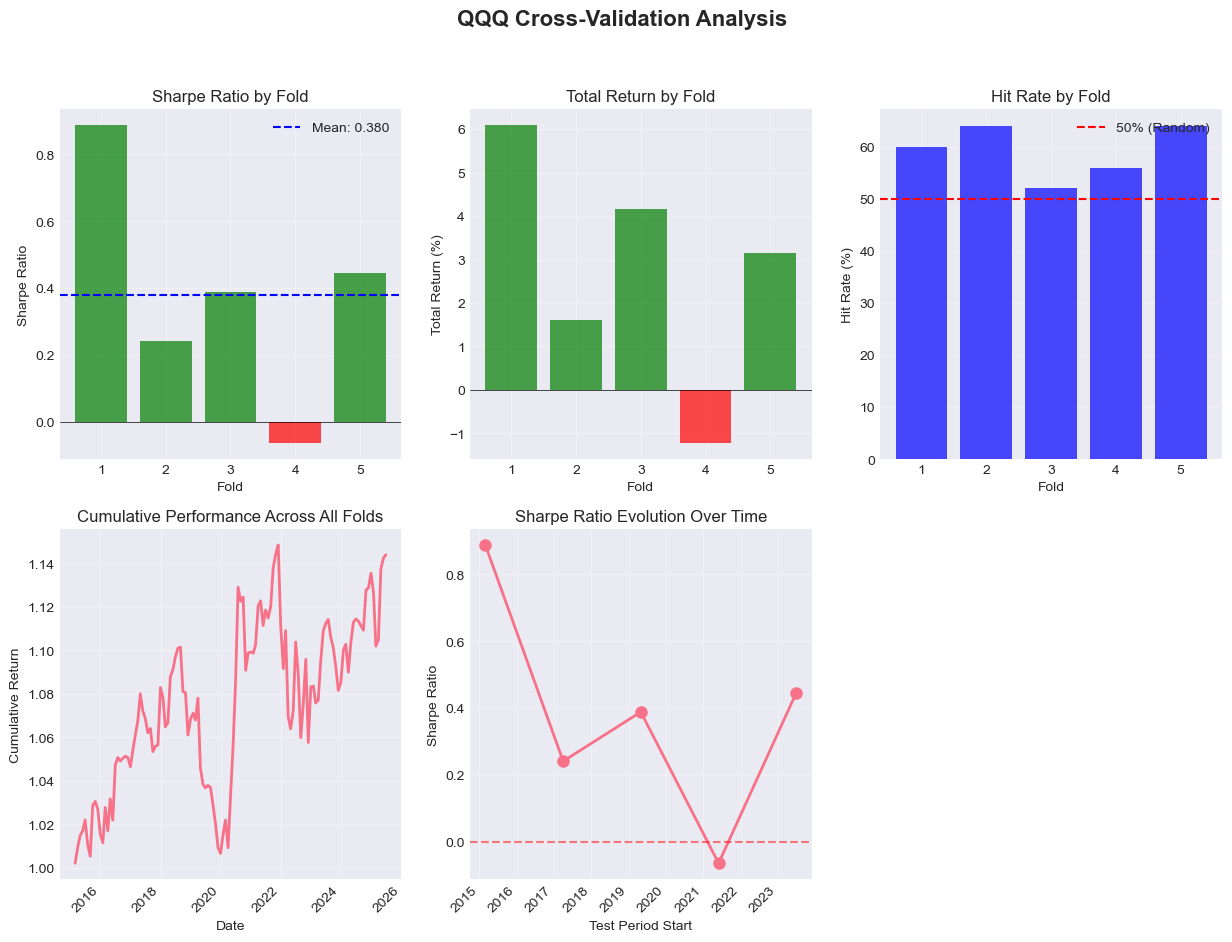


COMPARATIVE ANALYSIS
      Metric       SPY       QQQ
 Mean Sharpe  0.636488  0.379764
  Std Sharpe  0.816776  0.345541
 Best Sharpe  1.898253  0.887183
Worst Sharpe -0.268878 -0.063598
Success Rate  0.800000  0.800000

Comparison saved to: cv_comparison_spy_qqq.csv

DETAILED CV ANALYSIS COMPLETE

You can now reference the following files in your paper:
  - spy_cv_fold_results.csv (specific period Sharpe ratios)
  - qqq_cv_fold_results.csv (specific period Sharpe ratios)
  - spy_cv_detailed_analysis.png (visualizations)
  - qqq_cv_detailed_analysis.png (visualizations)
  - cv_comparison_spy_qqq.csv (comparative metrics)


In [ ]:
from datetime import datetime


def enhanced_walk_forward_validation(tkr,F_all,clean,n_splits=5,verbose=True):
    ret_col=f"{tkr.lower()}_ret";other="qqq" if tkr=="SPY" else "spy"
    exclude_patterns=[f"{other}_price",f"{other}_ret"]
    base=clean.drop(columns=[c for c in clean.columns if any(pattern in c for pattern in exclude_patterns)],errors="ignore")
    if ret_col not in base.columns:
        if ret_col in F_all.columns:df=base.join(F_all[[ret_col]],how="inner").dropna()
        else:return pd.DataFrame()
    else:df=base.dropna()
    df=create_aligned_targets(df,ret_col,forecast_horizon=1)
    if len(df)<n_splits*24:return pd.DataFrame()
    test_size=max(12,int(len(df)/(n_splits*2)));tscv=TimeSeriesSplit(n_splits=n_splits,test_size=test_size)
    fold_results=[];all_predictions=[]
    for fold,(train_idx,test_idx) in enumerate(tscv.split(df),1):
        train_data=df.iloc[train_idx];test_data=df.iloc[test_idx]
        if len(train_data)<20 or len(test_data)<3:continue
        train_start=train_data.index[0];train_end=train_data.index[-1]
        test_start=test_data.index[0];test_end=test_data.index[-1]
        sel_cols=strict_prune(train_data.drop(columns="y"))
        if len(sel_cols.columns)==0:continue
        Xtr,ytr=train_data[sel_cols.columns],train_data["y"];Xte,yte=test_data[sel_cols.columns],test_data["y"]
        if Xtr.isna().any().any() or ytr.isna().any():
            mask=~(Xtr.isna().any(axis=1)|ytr.isna());Xtr,ytr=Xtr[mask],ytr[mask]
        if Xte.isna().any().any() or yte.isna().any():
            mask=~(Xte.isna().any(axis=1)|yte.isna());Xte,yte=Xte[mask],yte[mask]
        if len(Xtr)<10 or len(Xte)<2:continue
        fitted_models,scalers=build_ensemble_model(Xtr,ytr)
        mu_pred=ensemble_predict(fitted_models,scalers,Xte)
        train_preds=ensemble_predict(fitted_models,scalers,Xtr);train_sigma=np.std(train_preds)+1e-12
        if not np.all(np.isfinite(mu_pred)):mu_pred=np.nan_to_num(mu_pred,nan=0.0)
        mu_smooth=apply_kalman_smoothing(mu_pred);weights=calculate_weights_continuous(mu_smooth,train_sigma=train_sigma)
        strat_ret=weights*yte.values;fold_sharpe=0
        if len(yte)>1 and strat_ret.std()>1e-10:fold_sharpe=(strat_ret.mean()/strat_ret.std())*np.sqrt(12)
        mse=np.mean((yte.values-mu_smooth)**2);mae=np.mean(np.abs(yte.values-mu_smooth))
        hit_rate=(np.sign(mu_smooth)==np.sign(yte.values)).mean()
        y_binary=(yte.values>0).astype(int)
        if len(np.unique(y_binary))>1:
            from sklearn.metrics import roc_auc_score
            roc_auc=roc_auc_score(y_binary,mu_smooth)
        else:roc_auc=0.5
        cum_return=np.prod(1+strat_ret)-1
        fold_result={'Fold':fold,'Train_Start':train_start.strftime('%Y-%m-%d'),'Train_End':train_end.strftime('%Y-%m-%d'),
                    'Test_Start':test_start.strftime('%Y-%m-%d'),'Test_End':test_end.strftime('%Y-%m-%d'),
                    'Train_Months':len(train_data),'Test_Months':len(test_data),'Sharpe_Ratio':fold_sharpe,
                    'Total_Return':cum_return*100,'Annualized_Return':((1+cum_return)**(12/len(test_data))-1)*100,
                    'Hit_Rate':hit_rate*100,'ROC_AUC':roc_auc,'MSE':mse,'MAE':mae,'Avg_Position':np.mean(np.abs(weights)),
                    'Max_Position':np.max(np.abs(weights)),'N_Trades':np.sum(np.abs(np.diff(weights))>0.01)}
        fold_results.append(fold_result)
        for i,idx in enumerate(yte.index):
            all_predictions.append({'Date':idx,'Fold':fold,'Actual':yte.iloc[i],'Predicted':mu_smooth[i],
                                  'Weight':weights[i],'Return':strat_ret[i]})
        if verbose:print(f"\nFold {fold}: {test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}\n  Sharpe: {fold_sharpe:.3f}, Return: {cum_return*100:.1f}%, Hit Rate: {hit_rate*100:.1f}%")
    fold_df=pd.DataFrame(fold_results);pred_df=pd.DataFrame(all_predictions)
    return fold_df,pred_df

def generate_cv_report(tkr,fold_df,pred_df,save_files=True):
    print(f"\n{tkr} DETAILED CROSS-VALIDATION RESULTS")
    print("\nFOLD-BY-FOLD PERFORMANCE:")
    display_cols=['Fold','Test_Start','Test_End','Test_Months','Sharpe_Ratio','Total_Return','Hit_Rate','ROC_AUC']
    print(fold_df[display_cols].to_string(index=False))
    print("\nSUMMARY STATISTICS:")
    summary_stats={'Mean_Sharpe':fold_df['Sharpe_Ratio'].mean(),'Std_Sharpe':fold_df['Sharpe_Ratio'].std(),
                  'Min_Sharpe':fold_df['Sharpe_Ratio'].min(),'Max_Sharpe':fold_df['Sharpe_Ratio'].max(),
                  'Mean_Return_%':fold_df['Total_Return'].mean(),'Mean_Hit_Rate_%':fold_df['Hit_Rate'].mean(),
                  'Mean_ROC_AUC':fold_df['ROC_AUC'].mean(),'Positive_Sharpe_Folds':(fold_df['Sharpe_Ratio']>0).sum(),
                  'Total_Folds':len(fold_df)}
    for key,value in summary_stats.items():
        if 'Sharpe' in key or 'ROC' in key:print(f"{key:20s}: {value:8.3f}")
        else:print(f"{key:20s}: {value:8.1f}")
    best_fold=fold_df.loc[fold_df['Sharpe_Ratio'].idxmax()];worst_fold=fold_df.loc[fold_df['Sharpe_Ratio'].idxmin()]
    print("\nNOTABLE PERIODS:")
    print(f"Best Period:  Fold {int(best_fold['Fold'])} ({best_fold['Test_Start']} to {best_fold['Test_End']})")
    print(f"              Sharpe: {best_fold['Sharpe_Ratio']:.3f}, Return: {best_fold['Total_Return']:.1f}%")
    print(f"Worst Period: Fold {int(worst_fold['Fold'])} ({worst_fold['Test_Start']} to {worst_fold['Test_End']})")
    print(f"              Sharpe: {worst_fold['Sharpe_Ratio']:.3f}, Return: {worst_fold['Total_Return']:.1f}%")
    
    fig,axes=plt.subplots(2,3,figsize=(15,10));axes[1,2].remove()
    fig.suptitle(f'{tkr} Cross-Validation Analysis',fontsize=16,fontweight='bold')
    ax1=axes[0,0];colors=['green' if x>0 else 'red' for x in fold_df['Sharpe_Ratio']]
    ax1.bar(fold_df['Fold'],fold_df['Sharpe_Ratio'],color=colors,alpha=0.7)
    ax1.axhline(y=0,color='black',linestyle='-',linewidth=0.5)
    ax1.axhline(y=fold_df['Sharpe_Ratio'].mean(),color='blue',linestyle='--',label=f'Mean: {fold_df["Sharpe_Ratio"].mean():.3f}')
    ax1.set_xlabel('Fold');ax1.set_ylabel('Sharpe Ratio');ax1.set_title('Sharpe Ratio by Fold')
    ax1.legend();ax1.grid(True,alpha=0.3)
    
    ax2=axes[0,1];colors=['green' if x>0 else 'red' for x in fold_df['Total_Return']]
    ax2.bar(fold_df['Fold'],fold_df['Total_Return'],color=colors,alpha=0.7)
    ax2.axhline(y=0,color='black',linestyle='-',linewidth=0.5)
    ax2.set_xlabel('Fold');ax2.set_ylabel('Total Return (%)');ax2.set_title('Total Return by Fold')
    ax2.grid(True,alpha=0.3)
    
    ax3=axes[0,2];ax3.bar(fold_df['Fold'],fold_df['Hit_Rate'],color='blue',alpha=0.7)
    ax3.axhline(y=50,color='red',linestyle='--',label='50% (Random)')
    ax3.set_xlabel('Fold');ax3.set_ylabel('Hit Rate (%)');ax3.set_title('Hit Rate by Fold')
    ax3.legend();ax3.grid(True,alpha=0.3)
    
    ax4=axes[1,0]
    if not pred_df.empty:
        pred_df_sorted=pred_df.sort_values('Date')
        cum_returns=(1+pred_df_sorted.groupby('Date')['Return'].mean()).cumprod()
        ax4.plot(cum_returns.index,cum_returns.values,linewidth=2)
        ax4.set_xlabel('Date');ax4.set_ylabel('Cumulative Return')
        ax4.set_title('Cumulative Performance Across All Folds');ax4.grid(True,alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(),rotation=45,ha='right')
    
    ax5=axes[1,1];fold_dates=pd.to_datetime(fold_df['Test_Start'])
    ax5.plot(fold_dates,fold_df['Sharpe_Ratio'],'o-',linewidth=2,markersize=8)
    ax5.axhline(y=0,color='red',linestyle='--',alpha=0.5)
    ax5.set_xlabel('Test Period Start');ax5.set_ylabel('Sharpe Ratio')
    ax5.set_title('Sharpe Ratio Evolution Over Time');ax5.grid(True,alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(),rotation=45,ha='right')
    
    if save_files:
        fig_filename=f'{tkr.lower()}_cv_detailed_analysis.png'
        plt.savefig(fig_filename,dpi=150,bbox_inches='tight')
        print(f"\nVisualization saved to: {fig_filename}")
        fold_filename=f'{tkr.lower()}_cv_fold_results.csv'
        fold_df.to_csv(fold_filename,index=False)
        print(f"Fold results saved to: {fold_filename}")
        pred_filename=f'{tkr.lower()}_cv_all_predictions.csv'
        pred_df.to_csv(pred_filename,index=False)
        print(f"All predictions saved to: {pred_filename}")
        summary_filename=f'{tkr.lower()}_cv_summary.txt'
        with open(summary_filename,'w') as f:
            f.write(f"{tkr} Cross-Validation Summary\n\n")
            f.write("Fold-by-Fold Results:\n");f.write(fold_df.to_string(index=False))
            f.write("\n\nSummary Statistics:\n")
            for key,value in summary_stats.items():f.write(f"{key:30s}: {value:10.3f}\n")
        print(f"Summary saved to: {summary_filename}")
    plt.show()
    return summary_stats

def run_detailed_cv_analysis():
    global F_all,clean
    detailed_results={}
    for ticker in ['SPY','QQQ']:
        print(f"\nRunning Detailed CV Analysis for {ticker}")
        fold_df,pred_df=enhanced_walk_forward_validation(ticker,F_all,clean,n_splits=5,verbose=True)
        if not fold_df.empty:
            summary=generate_cv_report(ticker,fold_df,pred_df,save_files=True)
            detailed_results[ticker]={'fold_results':fold_df,'predictions':pred_df,'summary':summary}
        else:print(f"No valid results for {ticker}")
    if len(detailed_results)==2:
        print("\nCOMPARATIVE ANALYSIS")
        comparison_df=pd.DataFrame({'Metric':['Mean Sharpe','Std Sharpe','Best Sharpe','Worst Sharpe','Success Rate'],
            'SPY':[detailed_results['SPY']['summary']['Mean_Sharpe'],detailed_results['SPY']['summary']['Std_Sharpe'],
                  detailed_results['SPY']['summary']['Max_Sharpe'],detailed_results['SPY']['summary']['Min_Sharpe'],
                  detailed_results['SPY']['summary']['Positive_Sharpe_Folds']/detailed_results['SPY']['summary']['Total_Folds']],
            'QQQ':[detailed_results['QQQ']['summary']['Mean_Sharpe'],detailed_results['QQQ']['summary']['Std_Sharpe'],
                  detailed_results['QQQ']['summary']['Max_Sharpe'],detailed_results['QQQ']['summary']['Min_Sharpe'],
                  detailed_results['QQQ']['summary']['Positive_Sharpe_Folds']/detailed_results['QQQ']['summary']['Total_Folds']]})
        print(comparison_df.to_string(index=False))
        comparison_df.to_csv('cv_comparison_spy_qqq.csv',index=False)
        print("\nComparison saved to: cv_comparison_spy_qqq.csv")
    return detailed_results

if __name__=="__main__":
    cv_detailed_results=run_detailed_cv_analysis()
    print("\nDETAILED CV ANALYSIS COMPLETE")
    print("\nYou can now reference the following files in your paper:")
    print("  - spy_cv_fold_results.csv (specific period Sharpe ratios)")
    print("  - qqq_cv_fold_results.csv (specific period Sharpe ratios)")
    print("  - spy_cv_detailed_analysis.png (visualizations)")
    print("  - qqq_cv_detailed_analysis.png (visualizations)")
    print("  - cv_comparison_spy_qqq.csv (comparative metrics)")

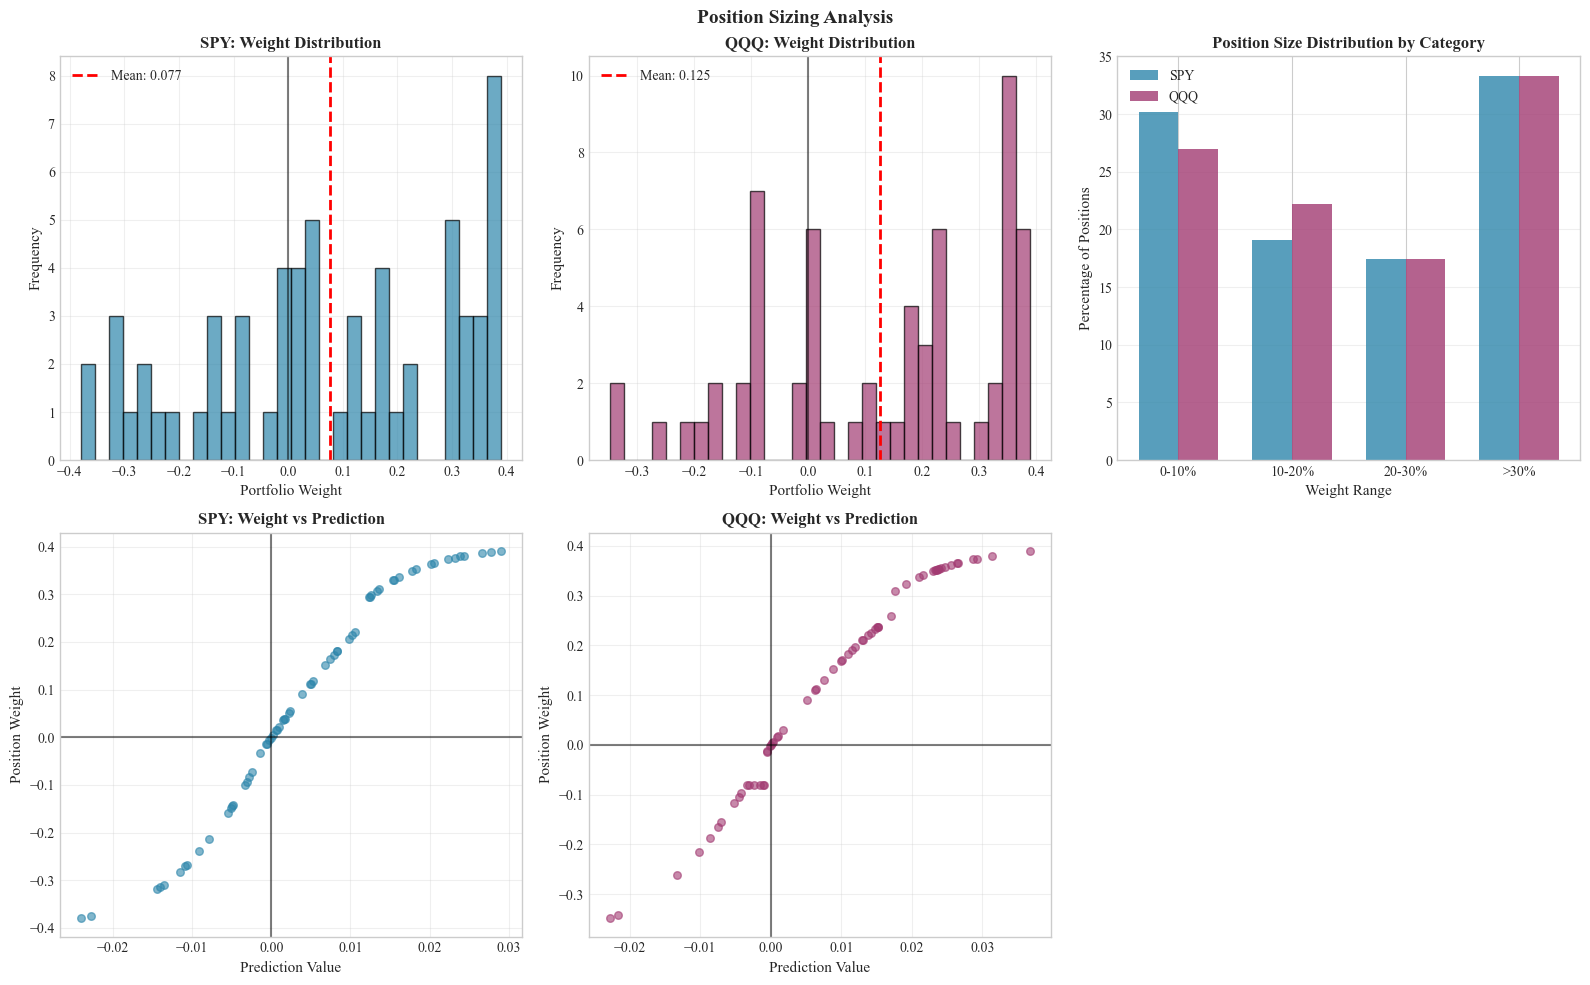

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi']=100;plt.rcParams['savefig.dpi']=300
plt.rcParams['font.size']=10;plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']=['Times New Roman']

def load_actual_results():
    spy_forecast=pd.read_csv('spy_forecast_detail.csv',index_col=0,parse_dates=True)
    qqq_forecast=pd.read_csv('qqq_forecast_detail.csv',index_col=0,parse_dates=True)
    metrics=pd.read_csv('05_metrics_reg.csv',index_col=0)
    portfolio_results=pd.read_csv('portfolio_results.csv',index_col=0,parse_dates=True)
    spy_features=pd.read_csv('spy_selected_features.csv');qqq_features=pd.read_csv('qqq_selected_features.csv')
    return {'spy_forecast':spy_forecast,'qqq_forecast':qqq_forecast,'metrics':metrics,
            'portfolio':portfolio_results,'spy_features':spy_features,'qqq_features':qqq_features}


def create_figure_3_weight_distribution(data):
    spy_data=data['spy_forecast'];qqq_data=data['qqq_forecast']
    fig,axes=plt.subplots(2,3,figsize=(16,10));axes[1,2].axis("off")
    
    ax=axes[0,0];weights=spy_data['weight'].values;weights_nonzero=weights[weights!=0]
    ax.hist(weights_nonzero,bins=30,edgecolor='black',alpha=0.7,color='#2E86AB')
    ax.axvline(np.mean(weights_nonzero),color='red',linestyle='--',lw=2,label=f'Mean: {np.mean(weights_nonzero):.3f}')
    ax.axvline(0,color='black',linestyle='-',alpha=0.5)
    ax.set_xlabel('Portfolio Weight',fontsize=11);ax.set_ylabel('Frequency',fontsize=11)
    ax.set_title('SPY: Weight Distribution',fontsize=12,fontweight='bold');ax.legend();ax.grid(True,alpha=0.3)
    
    ax=axes[0,1];weights=qqq_data['weight'].values;weights_nonzero=weights[weights!=0]
    ax.hist(weights_nonzero,bins=30,edgecolor='black',alpha=0.7,color='#A23B72')
    ax.axvline(np.mean(weights_nonzero),color='red',linestyle='--',lw=2,label=f'Mean: {np.mean(weights_nonzero):.3f}')
    ax.axvline(0,color='black',linestyle='-',alpha=0.5)
    ax.set_xlabel('Portfolio Weight',fontsize=11);ax.set_ylabel('Frequency',fontsize=11)
    ax.set_title('QQQ: Weight Distribution',fontsize=12,fontweight='bold');ax.legend();ax.grid(True,alpha=0.3)
    
    ax=axes[1,0];predictions=spy_data['mu_kalman'].values;weights=spy_data['weight'].values
    ax.scatter(predictions,weights,alpha=0.6,s=30,color='#2E86AB')
    ax.set_xlabel('Prediction Value',fontsize=11);ax.set_ylabel('Position Weight',fontsize=11)
    ax.set_title('SPY: Weight vs Prediction',fontsize=12,fontweight='bold');ax.grid(True,alpha=0.3)
    ax.axhline(0,color='black',linestyle='-',alpha=0.5);ax.axvline(0,color='black',linestyle='-',alpha=0.5)
    
    ax=axes[1,1];predictions=qqq_data['mu_kalman'].values;weights=qqq_data['weight'].values
    ax.scatter(predictions,weights,alpha=0.6,s=30,color='#A23B72')
    ax.set_xlabel('Prediction Value',fontsize=11);ax.set_ylabel('Position Weight',fontsize=11)
    ax.set_title('QQQ: Weight vs Prediction',fontsize=12,fontweight='bold');ax.grid(True,alpha=0.3)
    ax.axhline(0,color='black',linestyle='-',alpha=0.5);ax.axvline(0,color='black',linestyle='-',alpha=0.5)
    
    ax=axes[0,2];spy_weights=spy_data['weight'].abs().values;qqq_weights=qqq_data['weight'].abs().values
    categories=['0-10%','10-20%','20-30%','>30%']
    spy_dist=[np.sum(spy_weights<=0.1)/len(spy_weights)*100,
             np.sum((spy_weights>0.1)&(spy_weights<=0.2))/len(spy_weights)*100,
             np.sum((spy_weights>0.2)&(spy_weights<=0.3))/len(spy_weights)*100,
             np.sum(spy_weights>0.3)/len(spy_weights)*100]
    qqq_dist=[np.sum(qqq_weights<=0.1)/len(qqq_weights)*100,
             np.sum((qqq_weights>0.1)&(qqq_weights<=0.2))/len(qqq_weights)*100,
             np.sum((qqq_weights>0.2)&(qqq_weights<=0.3))/len(qqq_weights)*100,
             np.sum(qqq_weights>0.3)/len(qqq_weights)*100]
    x=np.arange(len(categories));width=0.35
    ax.bar(x-width/2,spy_dist,width,label='SPY',color='#2E86AB',alpha=0.8)
    ax.bar(x+width/2,qqq_dist,width,label='QQQ',color='#A23B72',alpha=0.8)
    ax.set_xlabel('Weight Range',fontsize=11);ax.set_ylabel('Percentage of Positions',fontsize=11)
    ax.set_title('Position Size Distribution by Category',fontsize=12,fontweight='bold')
    ax.set_xticks(x);ax.set_xticklabels(categories);ax.legend();ax.grid(True,alpha=0.3,axis='y')
    
    plt.suptitle('Position Sizing Analysis',fontsize=14,fontweight='bold')
    plt.tight_layout();plt.savefig('figure3_weight_distribution.png',dpi=300,bbox_inches='tight');plt.show()

def generate_all_research_outputs():
    data=load_actual_results()
    create_figure_3_weight_distribution(data)
    return data

if __name__=="__main__":
    results=generate_all_research_outputs()

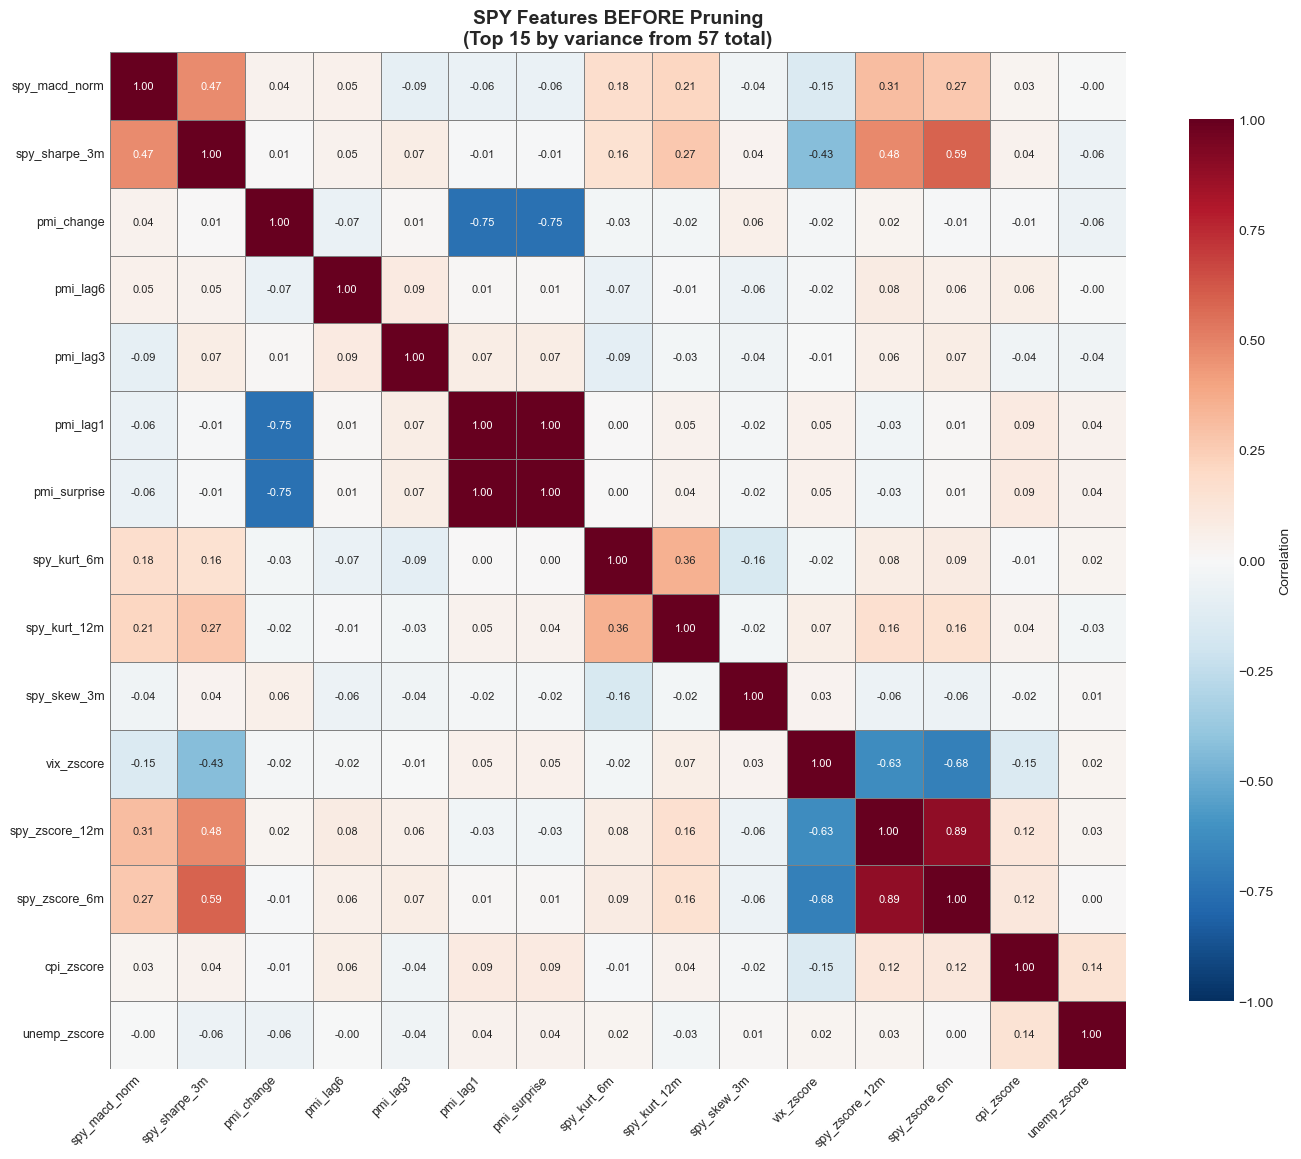

  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
  Final: 35 features selected


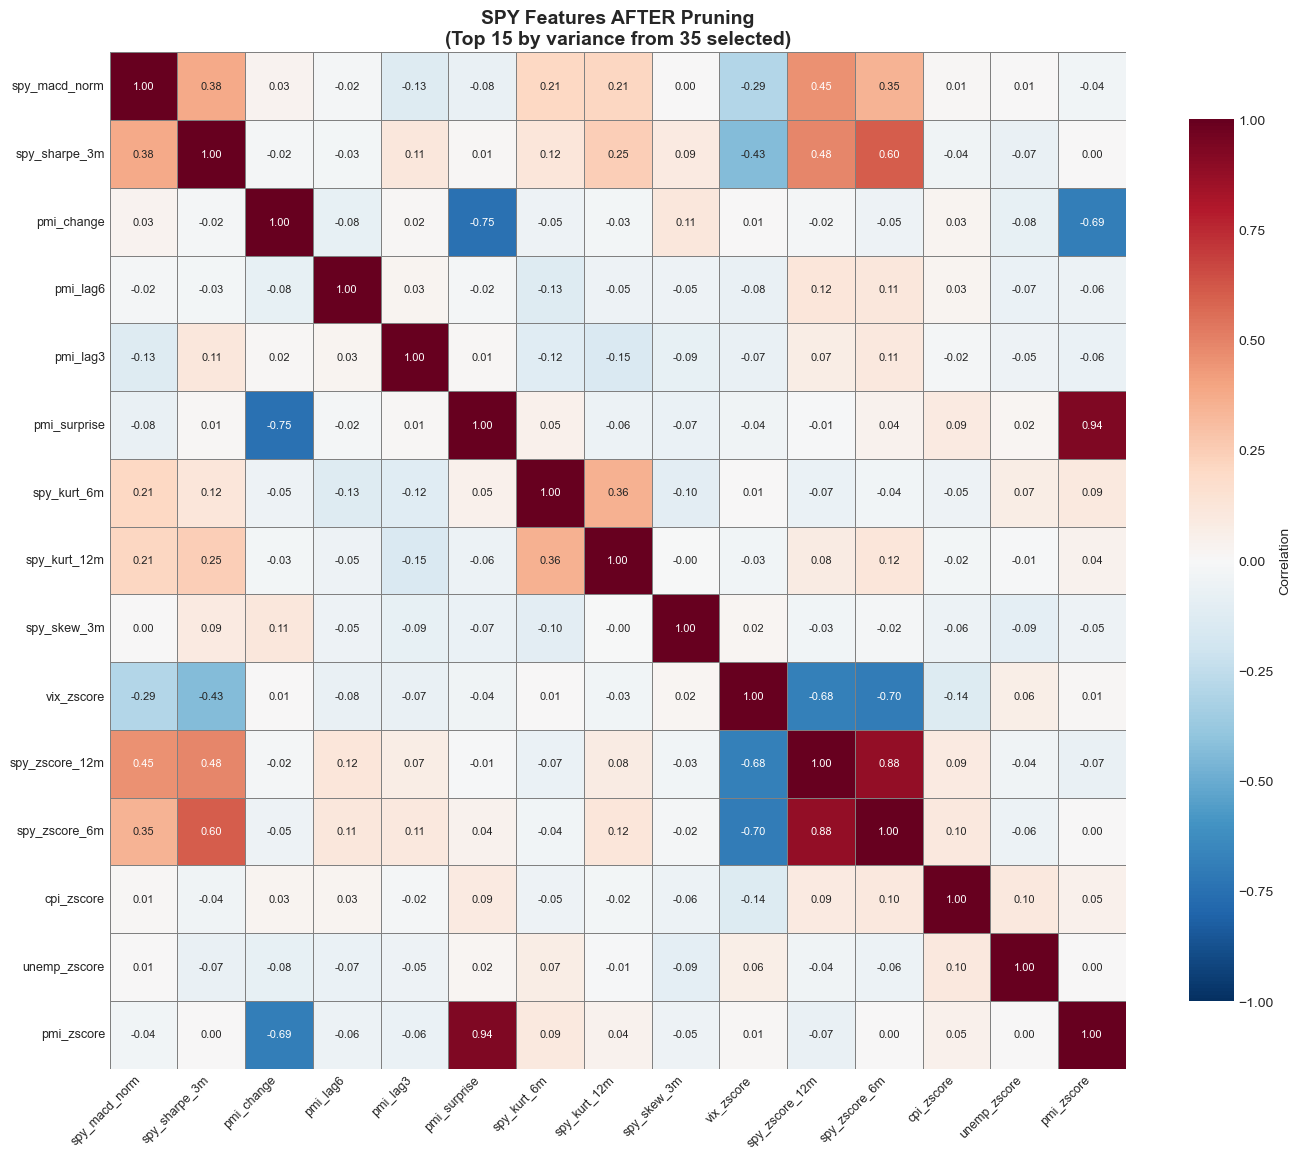

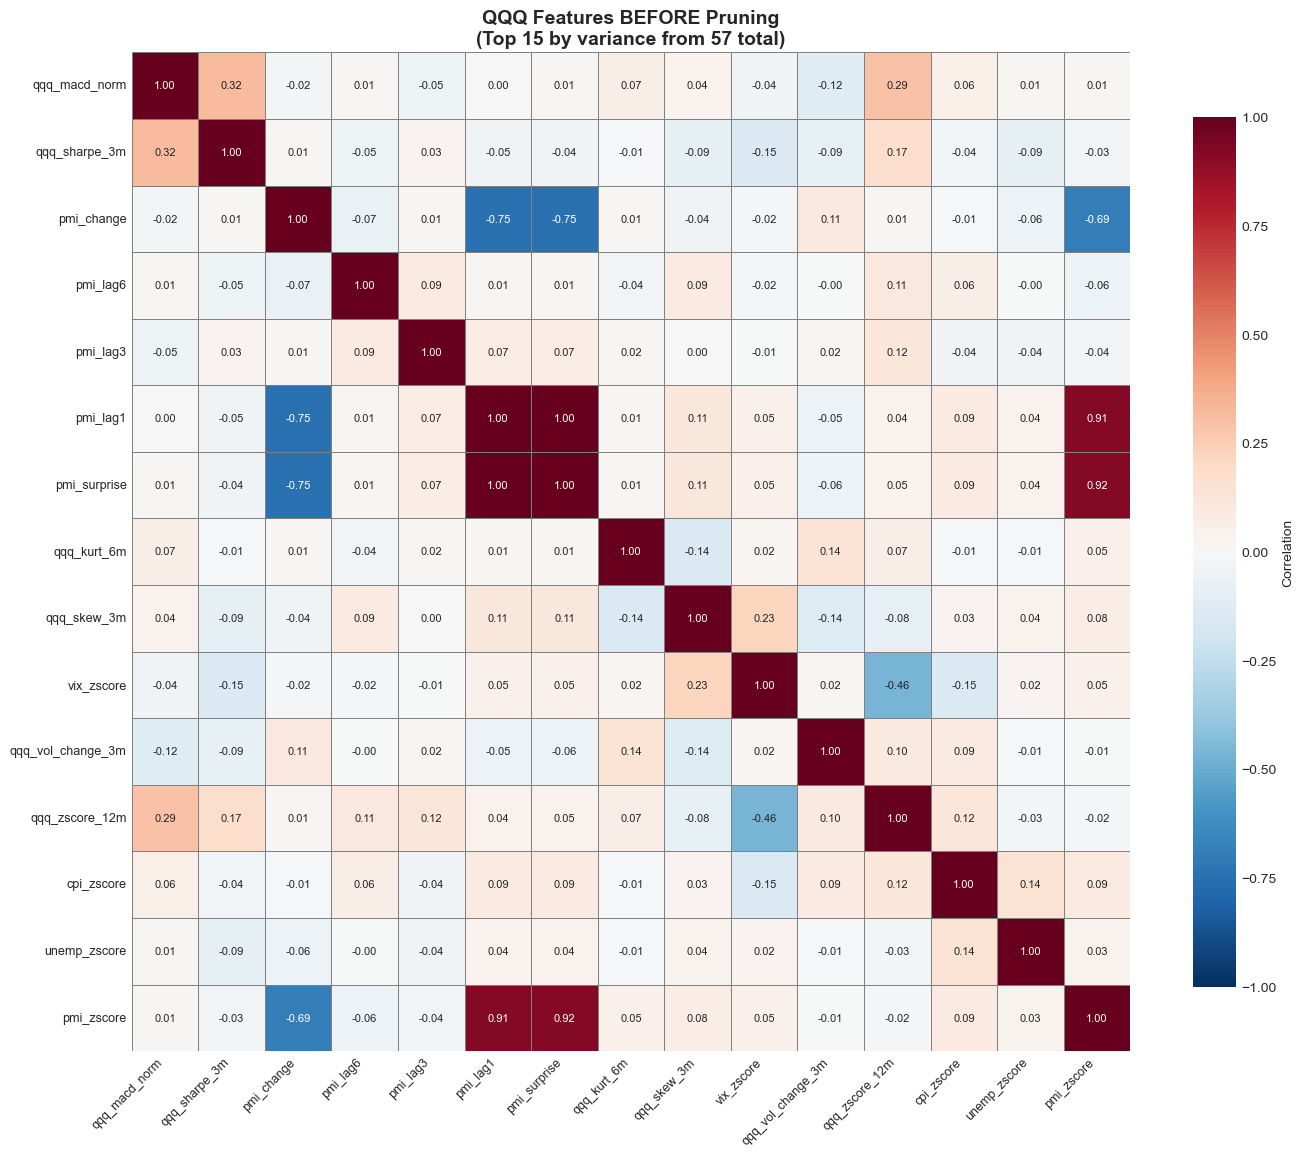

  Removed 2 low-variance features
    Dropped cpi_lag1 (corr=1.000)
    Dropped pmi_lag1 (corr=1.000)
    Dropped unemp_lag1 (corr=1.000)
  Final: 35 features selected


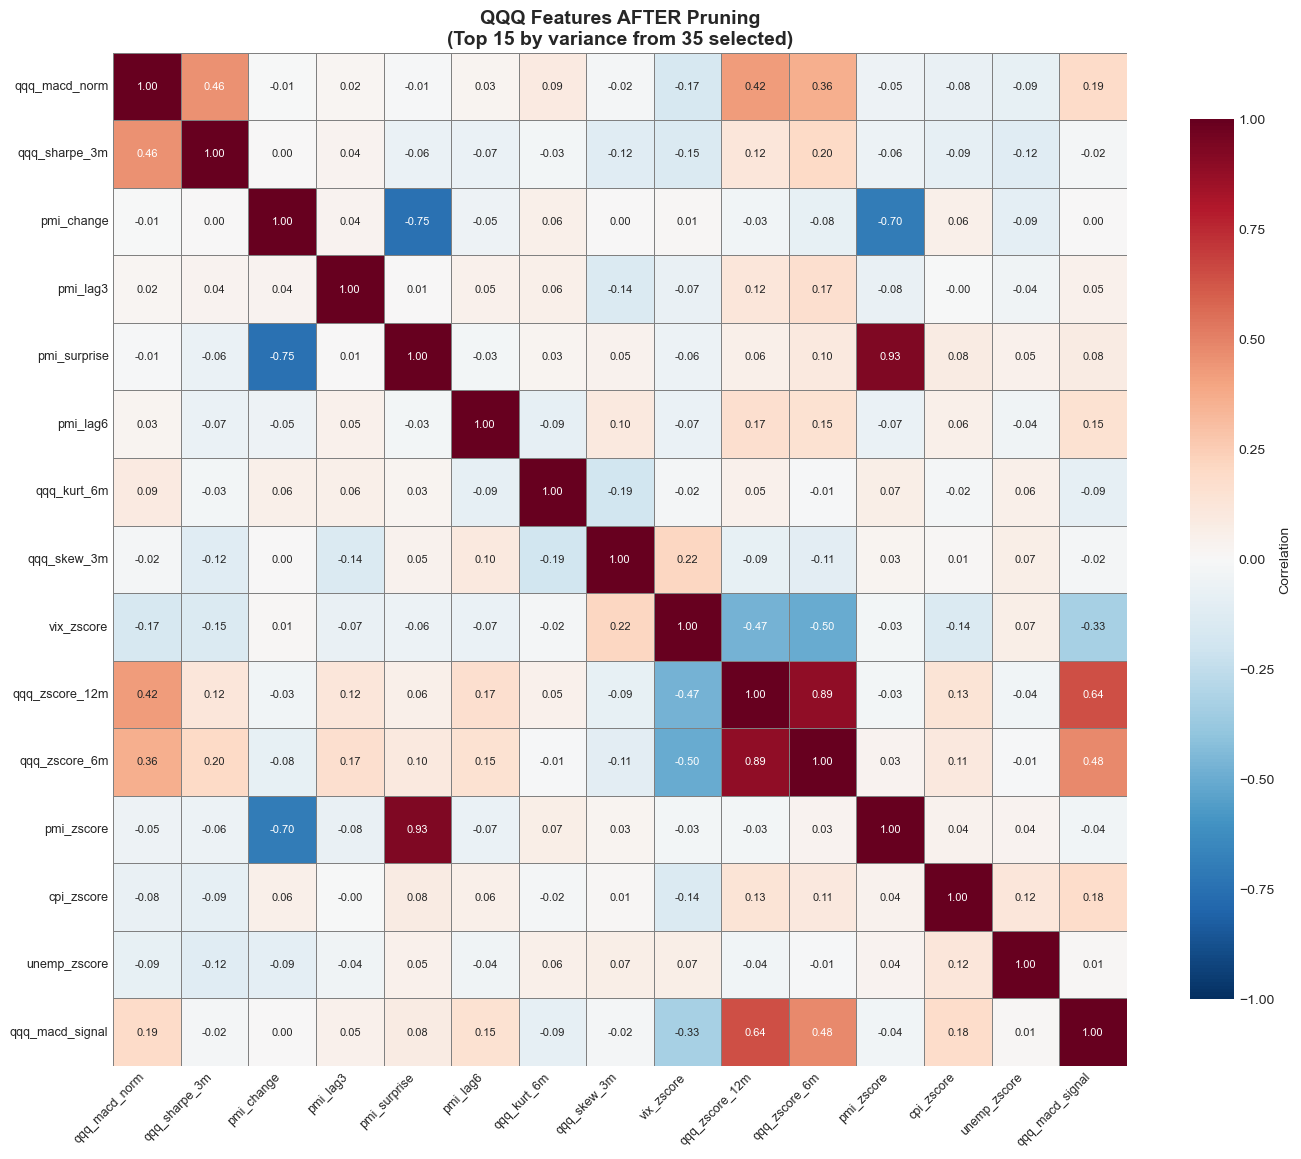

In [ ]:
def generate_heatmaps_for_ticker(tkr,F_all,clean,TOP_K=35,MAX_CORR=0.95):
    ret_col=f"{tkr.lower()}_ret";other="qqq" if tkr=="SPY" else "spy"
    exclude_cols=[c for c in clean.columns if other.lower() in c.lower() or c==ret_col]
    base=clean.drop(columns=exclude_cols,errors='ignore')
    n_display=min(15,len(base.columns));top_var_cols=base.var().nlargest(n_display).index
    
    plt.figure(figsize=(14,12))
    before_df=base[top_var_cols].dropna();corr_before=before_df.corr()
    ax=sns.heatmap(corr_before,vmin=-1,vmax=1,cmap='RdBu_r',center=0,square=True,linewidths=0.5,
                   linecolor='gray',cbar_kws={'label':'Correlation','shrink':0.8},annot=True,fmt='.2f',annot_kws={'size':8})
    plt.title(f"{tkr} Features BEFORE Pruning\n(Top {n_display} by variance from {len(base.columns)} total)",
              fontsize=14,fontweight='bold')
    plt.xlabel('');plt.ylabel('');plt.xticks(rotation=45,ha='right',fontsize=9);plt.yticks(rotation=0,fontsize=9)
    plt.tight_layout()
    before_filename=f'{tkr.lower()}_before_prune_heatmap.png'
    plt.savefig(before_filename,dpi=150,bbox_inches='tight');plt.show()
    
    returns_series=F_all[[ret_col]].copy();returns_series.columns=['target_return']
    df_for_prune=base.join(returns_series,how='inner');df_for_prune['y']=df_for_prune['target_return'].shift(-1)
    df_for_prune=df_for_prune.dropna(subset=['y'])
    if len(df_for_prune)<30:return pd.DataFrame()
    cut=int(len(df_for_prune)*0.75);train_data=df_for_prune.iloc[:cut]
    features_to_prune=train_data.drop(columns=['y','target_return'],errors='ignore')
    sel_cols=strict_prune(features_to_prune,max_corr=MAX_CORR,k=TOP_K)
    if len(sel_cols.columns)==0:return pd.DataFrame()
    
    n_display_after=min(15,len(sel_cols.columns))
    if len(sel_cols.columns)>n_display_after:
        top_pruned_cols=sel_cols.var().nlargest(n_display_after).index
        after_df=sel_cols[top_pruned_cols].dropna()
        display_text=f"(Top {n_display_after} by variance from {len(sel_cols.columns)} selected)"
    else:
        after_df=sel_cols.dropna();display_text=f"({len(sel_cols.columns)} selected features)"
    
    plt.figure(figsize=(14,12));corr_after=after_df.corr()
    ax=sns.heatmap(corr_after,vmin=-1,vmax=1,cmap='RdBu_r',center=0,square=True,linewidths=0.5,
                   linecolor='gray',cbar_kws={'label':'Correlation','shrink':0.8},annot=True,fmt='.2f',annot_kws={'size':8})
    plt.title(f"{tkr} Features AFTER Pruning\n{display_text}",fontsize=14,fontweight='bold')
    plt.xlabel('');plt.ylabel('');plt.xticks(rotation=45,ha='right',fontsize=9);plt.yticks(rotation=0,fontsize=9)
    plt.tight_layout()
    after_filename=f'{tkr.lower()}_after_prune_heatmap.png'
    plt.savefig(after_filename,dpi=150,bbox_inches='tight');plt.show()
    
    feature_file=f'{tkr.lower()}_selected_features_list.csv'
    pd.DataFrame({'feature':sel_cols.columns}).to_csv(feature_file,index=False)
    return sel_cols

def main():
    F_all=pd.read_csv("feature_matrix_full.csv",index_col=0,parse_dates=True)
    clean=pd.read_csv("02_clean_preprune.csv",index_col=0,parse_dates=True)
    TOP_K=35;MAX_CORR=0.95;results={}
    for ticker in ['SPY','QQQ']:
        selected_features=generate_heatmaps_for_ticker(ticker,F_all,clean,TOP_K=TOP_K,MAX_CORR=MAX_CORR)
        results[ticker]=selected_features
    return results

if __name__=="__main__":
    selected_features_dict=main()